In [1]:
#DEVELOPED 3D-GAN ARCHITECTURE IN PYTHON, TENSORFLOW

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import zoom

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Conv3D, Input, LeakyReLU, Reshape, Conv3DTranspose, ReLU, BatchNormalization, Flatten, Dense, Add, Concatenate, GlobalAveragePooling2D, Average, Lambda


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

In [5]:
ct_path = "Data/CT_Volumes/"
ct_scan_files = sorted([os.path.join(ct_path,f) for f in 
                        os.listdir(ct_path) if f.endswith(".nii.gz")])

In [6]:
def load_nifti(file_path):
    nifti_img = nib.load(file_path)
    img_array = nifti_img.get_fdata()#Converting to numpy array
    return img_array

In [7]:
#dynamically load nifti files one at a time 
def data_generator():
    for file in ct_scan_files:
        scan = load_nifti(file)
        scan = scan.astype(np.float32)
        scan = scan.transpose((2,0,1))
        yield scan 

In [8]:
#Load and process CT scans dynamically - 
#low RAM size so-
#using Tensorflow to efficiently manage batching
ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature = 
    tf.TensorSpec(shape=(None,512,512), 
                  dtype=tf.float32)
)

2025-05-11 10:37:24.500490: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-11 10:37:24.500765: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-11 10:37:24.500779: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-11 10:37:24.501192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-11 10:37:24.501242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#PREPROCESS CT SCANS
def preprocess(scan, target_size=(128,128,128)):
    scan = (scan - np.min(scan)) / 
    (np.max(scan) - np.min(scan) + 1e-8)
    #normalise CT scans, avoid NAN
    
    #preprocessing each slice of scan 
    resized_slices = [
        tf.image.resize(slice[..., tf.newaxis], 
                        (target_size[0], 
                         target_size[1]), 
                        method='bilinear')[...,0]
        for slice in scan
    ]
    resized_scan = tf.stack(resized_slices,axis=0)
    #stacking back the slices into 3d tensor 
    
    df = target_size[2]/ resized_scan.shape[0]
    resized_scan = zoom(resized_scan, (df,1,1), order=1)
    
    return resized_scan 

In [10]:
ds = ds.map(lambda scan: tf.py_function(preprocess, [scan], tf.float32))
# ds = ds.batch(1)
#ds = ds.shuffle(10)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [11]:
#GENERATING SYNTHETIC X-RAYS

def gen_s_xrays(ct_scan):
    ct_scan = tf.squeeze(ct_scan)#removing batch-dim
    # print("in gen_s_xray:")
    # print("CT- ", ct_scan.shape)

    pa_xray = tf.reduce_max(ct_scan, axis=0)
    lat_xray = tf.reduce_max(ct_scan, axis=2)
    # print("PA- ", pa_xray.shape)
    # print("lat- ", lat_xray.shape)

    #normalising
    pa_xray = (pa_xray - tf.reduce_min(pa_xray)) / 
    (tf.reduce_max(pa_xray) - tf.reduce_min(pa_xray) + 1e-8)
    lat_xray = (lat_xray - tf.reduce_min(lat_xray)) / 
    (tf.reduce_max(lat_xray) - tf.reduce_min(lat_xray) + 1e-8)
    
    return pa_xray, lat_xray

In [12]:
precomp_d = []
for scan in ds:
    pa_xray,lat_xray = gen_s_xrays(scan)
    precomp_d.append((pa_xray.numpy(),lat_xray.numpy(), 
                      scan.numpy()))

2025-05-11 10:49:32.801695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
paired_ds = tf.data.Dataset.from_generator(
    lambda: iter(precomp_d),
    output_signature=(
         # PA X-ray
        tf.TensorSpec(shape=(128, 128), dtype=tf.float32), 
        # Lateral X-ray
        tf.TensorSpec(shape=(128, 128), dtype=tf.float32),  
        # Original CT scan
        tf.TensorSpec(shape=(128, 128, 128), dtype=tf.float32)  
    )
)

In [14]:
paired_ds = paired_ds.batch(1)
paired_ds = paired_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
paired_ds = paired_ds.shuffle(10)

In [127]:
def dense_block(xray_image, filters):

    #down-sampling block
    ds1 = Conv2D(filters,3,strides=2,padding="same")(xray_image)
    ds2 = LeakyReLU(alpha=0.2)(ds1)
    
    #Dense connectivity block - to improve feature extractions
    c1 = Conv2D(filters, 3, padding="same")(ds2)
    a1 = LeakyReLU(alpha=0.2)(c1)

    c2 = Conv2D(filters, 3, padding="same")(a1)
    a2 = LeakyReLU(alpha=0.2)(c2)

    c3 = Conv2D(filters, 3, padding="same")(a2)
    a3 = LeakyReLU(alpha=0.2)(c3)

    #densely-connecting conv. block
    concat = Concatenate()([ds2,c1,c2,c3])

    #compression block - halve no. of output channels
    compr = Conv2D(filters // 2, 1, padding="same")(concat)
    compr2 = LeakyReLU(alpha=0.2)(compr)
    
    return compr2

def encoder_decoder(xray_image):
    #Encode-decoder network for both posterior-anterior
    #& lateral x-ray images
    d1 = dense_block(xray_image, 64)
    d2 = dense_block(d1, 128)
    d3 = dense_block(d2, 256)

    c1 = Conv2D(256, 3, padding="same")(d3)
    a1 = LeakyReLU(alpha=0.2)(c1)

    #Connection A 
    p1 = GlobalAveragePooling2D()(a1)
    d4 = Dense(16*16*256, activation='relu')(p1)
    r1 = Reshape((16,16,256))(d4)

    return r1, [d1,d2,d3]

def expand_to_3D(x, depth_slices=16):
    #Convert 2d feature maps into pseudo-3d
    #By duplicating along new axis

    # print("shape before expansion: ", x.shape)
    
    if len(x.shape) == 4:#Ensuring input is of 4d
        x = tf.expand_dims(x, axis=1)#Adding depth-dimension at axis=1

    #tiling feature map along depth-dimension - creating pseudo 3d
    depth_incr = [1,depth_slices,1,1,1]
    x = tf.tile(x,depth_incr)

    if x.shape[-1] == 1 and x.shape[3] != 1:
        x = tf.transpose(x,[0,1,2,4,3])#swap last two dimensions

    # print("shape before expansion: ", x.shape)
 
    return x

def connectionB(encoder_features, decoder_features):
    skip_3d=[]

    for encoder_feat in encoder_features:
        #1 - Match channel size of encoder & decoder
        c1 = Conv2D(64, 3, padding="same")(encoder_feat)
        a1 = LeakyReLU(alpha=0.2)(c1)

        #2 - Expanding 2d features into to pseudo-3d
        Expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(a1)

        #3 - Apply Conv3D
        c2 = Conv3D(64, 3, padding="same")(Expanded)
        a2 = ReLU()(c2)

        skip_3d.append(a2)

    if len(decoder_features) != len(skip_3d):
        raise ValueError(
            "Mismatch in decoder and skip connection features!")

    merged_features = []

    #Aligning both shapes
    for decoder_feat, skip_feat in zip(decoder_features, skip_3d):
        if decoder_feat.shape[2:4] != skip_feat.shape[2:4]:
            skip_feat = Lambda(lambda x: tf.map_fn(
                        lambda y: tf.image.resize(y, 
                                                  size=
                                                  decoder_feat.
                                                  shape[2:4]), 
                        x, fn_output_signature=tf.float32),
                      output_shape=lambda s: (s[0], s[1], 
                                              decoder_feat.shape[2], 
                                              decoder_feat.shape[3], 
                                              s[-1]))(skip_feat)


        if decoder_feat.shape != skip_feat.shape:
            decoder_feat = Conv3D(skip_feat.shape[-1], kernel_size=3,
                                  padding='same')(decoder_feat) 
            
        merged_features.append(Add()([decoder_feat, skip_feat]))
        
    for decoder_feat, skip_feat in zip(decoder_features, skip_3d):
        print("Decoder Feature Shape:", decoder_feat.shape)
        print("Skip 3D Feature Shape:", skip_feat.shape)
    
    return merged_features

In [128]:
#GENERATOR

def build_generator():
    #posterior-anterior x-ray image
    input_PA = Input(shape=(128,128,3), name='input_PA')
    #lateral x-ray image
    input_L = Input(shape=(128,128,3), name='input_Lateral')
    
    #Encoder-decoder network for PA & L x-ray images
    PA_connectionA, PA_encoder_features = encoder_decoder(input_PA)
    L_connectionA, L_encoder_features = encoder_decoder(input_L)

    #Fuse PA & L features (averaging) - combine to produce 
    #one bi-planar x-ray image 
    fused_connectionA = Average()([PA_connectionA, L_connectionA])
    fused_encoder_features = [Average()([PA_feat, L_feat]) for 
                              PA_feat, L_feat in zip(PA_encoder_features, 
                                                     L_encoder_features)]


    Expanded = Lambda(lambda x: expand_to_3D(x,16), 
                      output_shape=lambda s: (s[0],16,s[1],s[2],s[3]))(
        fused_connectionA)
    decoder_features = [Expanded for _ in fused_encoder_features]
    
    decoder_features = connectionB(fused_encoder_features, 
                                   decoder_features)


    c1 = Conv3DTranspose(128, 4, strides=2, padding="same")(
        decoder_features[-1]) 
    b1 = BatchNormalization()(c1)
    a1 = ReLU()(b1)
    c2 = Conv3D(128,3,padding="same",activation="relu")(a1)

    c3 = Conv3DTranspose(64, 4, strides=2, padding="same")(c2)
    b2 = BatchNormalization()(c3)
    a2 = ReLU()(b2)
    c4 = Conv3D(64,3,padding="same",activation="relu")(a2)

    c5 = Conv3DTranspose(32, 4, strides=2, padding="same")(c4)
    b3 = BatchNormalization()(c5)
    a3 = ReLU()(b3)
    c6 = Conv3D(32,3,padding="same",activation="relu")(a3)

    outputs = Conv3D(1, 3, activation="sigmoid", padding="same")(c6)

    return Model(inputs=[input_PA,input_L], 
                 outputs=outputs, 
                 name="Generator")



In [129]:
generator = build_generator()

/Users/kaisei/X2CT/FMP_test/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Decoder Feature Shape: (None, 16, 16, 16, 256)
Skip 3D Feature Shape: (None, 1, 64, 64, 64)
Decoder Feature Shape: (None, 16, 16, 16, 256)
Skip 3D Feature Shape: (None, 1, 32, 32, 64)
Decoder Feature Shape: (None, 16, 16, 16, 256)
Skip 3D Feature Shape: (None, 1, 16, 16, 64)


In [18]:
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_PA            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Lateral       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 128,  │          0 │ input_PA[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 128, 128,  │          0 │ input_Lateral[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ cast[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      1,792 │ cast_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     36,928 │ leaky_re_lu_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ leaky_re_lu_17[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_2[0]

 Total params: 42,031,425 (160.34 MB)

 Trainable params: 42,030,977 (160.34 MB)

 Non-trainable params: 448 (1.75 KB)

In [130]:
from tensorflow.keras.layers import GroupNormalization

def build_discriminator():
    input = Input(shape=(128,128,128,1), name='input_CT')

    c1 = Conv3D(64, 4, strides=2, padding="same")(input)
    n1 = GroupNormalization(groups=32, axis=-1)(c1)
    a1 = LeakyReLU(alpha=0.2)(n1)

    c2 = Conv3D(128, 4, strides=2, padding="same")(a1)
    n2 = GroupNormalization(groups=32, axis=-1)(c2)
    a2 = LeakyReLU(alpha=0.2)(n2)

    c3 = Conv3D(256, 4, strides=2, padding="same")(a2)
    n3 = GroupNormalization(groups=32, axis=-1)(c3)
    a3 = LeakyReLU(alpha=0.2)(n3)
    
    c4 = Conv3D(512, 4, strides=1, padding="same")(a3)
    n4 = GroupNormalization(groups=32, axis=-1)(c4)
    a4 = LeakyReLU(alpha=0.2)(n4)

    output = Conv3D(1,4,strides=1,padding="same")(a4)
    
    return Model(inputs=[input], outputs=output, name="Discriminator")
    

In [131]:
discriminator = build_discriminator()

In [29]:
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_CT (InputLayer)           │ (None, 128, 128, 128,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 128, 128, 128,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 64, 64, 64, 64) │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_4           │ (None, 64, 64, 64, 64) │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 64, 64, 64, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 32, 32, 32,     │       524,416 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_5           │ (None, 32, 32, 32,     │           256 │
│ (GroupNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 32, 32, 32,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 16, 16, 16,     │     2,097,408 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_6           │ (None, 16, 16, 16,     │           512 │
│ (GroupNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 16, 16, 16,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 16, 16, 16,     │     8,389,120 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_7           │ (None, 16, 16, 16,     │         1,024 │
│ (GroupNormalization)            │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 16, 16, 16,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 16, 16, 16, 1)  │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,049,793 (42.15 MB)

 Trainable params: 11,049,793 (42.15 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
#3D render function
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ct_surface(ct_volume, threshold):
    verts, faces, _, _ = marching_cubes(ct_volume, level=threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.15, facecolor="orange")
    #alpha=0.15,cyan - good recommended
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("3D CT Volume Surface")
    
    plt.show()


In [22]:
#LOSS FUNCTIONS

import tensorflow.keras.backend as k 

def disc_adversarial_loss(real_output, fake_output):
    #implementing the LSGAN
    real_loss = k.mean(k.square(real_output-1))
    #real samples:1
    fake_loss = k.mean(k.square(fake_output))
    #fake samples:0
    return 0.5 * (real_loss + fake_loss)

def gen_adversarial_loss(fake_output):
    return 0.5 * k.mean(k.square(fake_output - 1))
    #fooling DISC.
    
def reconstruction_loss(real_CT, gen_CT):
    return k.mean(k.square(real_CT - gen_CT))
    #MSE Loss

def proj_average(ct, axis):
    return k.mean(ct, axis=axis)
    #average along axis to give 2D-proj

def projection_loss(real_ct, gen_ct):
    axial_proj = k.mean(k.abs(proj_average(real_ct,axis=0) - 
                              proj_average(gen_ct,axis=0)))
    coronal_proj = k.mean(k.abs(proj_average(real_ct,axis=1) - 
                                proj_average(gen_ct,axis=1)))
    sagittal_proj = k.mean(k.abs(proj_average(real_ct,axis=2) - 
                                 proj_average(gen_ct,axis=2)))
    return (axial_proj + coronal_proj + sagittal_proj) / 3 
    #aver. over 3 proj.

def gen_final_loss(real_ct, gen_ct, fake_output, lambda1=0.1, 
                   lambda2=10.0, lambda3=10.0):
    adver_loss = gen_adversarial_loss(fake_output)
    recon_loss = reconstruction_loss(real_ct, gen_ct)
    proj_loss = projection_loss(real_ct, gen_ct)
    return lambda1 * adver_loss + lambda2 * recon_loss + 
    lambda3 * proj_loss  
    #weighted loss sum

gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, 
                                   beta_1=0.5, 
                                   beta_2=0.99)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, 
                                    beta_1=0.5, 
                                    beta_2=0.99)



In [23]:
@tf.function

#TRAINING FUNCTION

def train_step(pa_xray, lat_xray, original_ct):
    original_ct = tf.cast(original_ct,tf.float32)#(1, 128, 128, 128, 1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        fake_ct = generator([pa_xray,lat_xray], training=True)
        # print("Inside train_step:")
        # print("out of generator- ", fake_ct.shape)
        # print("PA into gen.- ", pa_xray.shape)
        # print("Lateral into gen. - ", lat_xray.shape)
        # print("originalCT - ", original_ct.shape)

        fake_ct = tf.cast(fake_ct,tf.float32)
        
        real_output = discriminator(original_ct, training=True)
        fake_output = discriminator(fake_ct, training=True)

        disc_loss = disc_adversarial_loss(real_output,fake_output)
        # print(original_ct.dtype)
        # print(fake_ct.dtype)
        
        fake_output = tf.cast(fake_output,tf.float32)
        # print(fake_output.dtype)
        gen_loss = gen_final_loss(original_ct, fake_ct, fake_output)

    gen_grad = gen_tape.gradient(gen_loss, generator.
                                 trainable_variables)
    #calc. gradients
    disc_grad = disc_tape.gradient(disc_loss, discriminator.
                                   trainable_variables)

    gen_opt.apply_gradients(zip(gen_grad, generator.
                                trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, discriminator.
                                 trainable_variables))

    return gen_loss, disc_loss
    

In [26]:
epochs = 100

In [24]:
# os.makedirs("Checkpoints",exist_ok=True)
checkpoint_dir = "./Checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 
                          "checkpoint_{epoch}.weights.h5"),
    save_weights_only=True, 
    save_freq='epoch',
    verbose=1
)

In [ ]:
#loading from saved checkpoint
generator.load_weights("Checkpoints/generator_epoch_##.h5")
discriminator.load_weights("Checkpoints/discriminator_epoch_##.h5")



In [28]:
#MY CUSTOM TRAINING LOOP
for epoch in range(epochs):
    count=0
    save_dir = "Generated_Volumes"
    if epoch % 70 == 0:
        epoch_dir = os.path.join(save_dir, f"epoch_{epoch}")  
        os.makedirs(epoch_dir, exist_ok=True)

    for pa_xray, lat_xray, original_ct in paired_ds:
        # print(pa_xray.shape)#(1,128,128)
        # print(lat_xray.shape)#(1,128,128)
        # print(original_ct.shape)#(1,128,128,128) 
        
        pa_xray=tf.expand_dims(pa_xray,axis=-1)
        #adding extra dimension so (1,128,128, *new*)
        pa_xray = tf.repeat(pa_xray,3,axis=-1)
        #fill new dimension with 3
        
        lat_xray=tf.expand_dims(lat_xray,axis=-1)
        lat_xray=tf.repeat(lat_xray,3,axis=-1)

        original_ct=tf.expand_dims(original_ct,axis=-1)
        #(1,128,128,128,1)

        # print("After: ")
        # print(pa_xray.shape)#(1,128,128,3)
        # print(lat_xray.shape)#(1,128,128,3)
        # print(original_ct.shape)#(1,128,128,128,3) 

        gen_loss, disc_loss = train_step(pa_xray, lat_xray, original_ct)

        count += 1 
        # break

        print(f'Epoch {epoch}, Count {count}, Generator Loss {gen_loss}, 
        Discriminator Loss {disc_loss}')

        if count % 70 == 0:
            generated_vol = generator([pa_xray,lat_xray], 
                                      training=False)
            generated_vol = generated_vol.numpy()[0]
            np.save(os.path.join(epoch_dir, f"generated_ct{count}.npy"), 
                    generated_vol)
            print(f"Saved CT at Count {count}")


print("Training complete")

Epoch 0, Count 1, Generator Loss 0.7487086057662964, Discriminator Loss 0.646437406539917
Epoch 0, Count 2, Generator Loss 3.700521469116211, Discriminator Loss 0.872742772102356
Epoch 0, Count 3, Generator Loss 0.9735735654830933, Discriminator Loss 1.2154812812805176
Epoch 0, Count 4, Generator Loss 1.2522656917572021, Discriminator Loss 1.9942426681518555
Epoch 0, Count 5, Generator Loss 1.1596933603286743, Discriminator Loss 2.3071420192718506
Epoch 0, Count 6, Generator Loss 0.9252431392669678, Discriminator Loss 1.559700846672058
Epoch 0, Count 7, Generator Loss 1.6384422779083252, Discriminator Loss 0.6980348825454712
Epoch 0, Count 8, Generator Loss 1.7825042009353638, Discriminator Loss 0.3302472233772278
Epoch 0, Count 9, Generator Loss 0.7460547089576721, Discriminator Loss 0.1728023737668991
Epoch 0, Count 10, Generator Loss 1.0531078577041626, Discriminator Loss 0.3172340989112854
Epoch 0, Count 11, Generator Loss 0.8327935338020325, Discriminator Loss 0.23766322433948517


2025-04-12 02:52:21.993861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Count 1, Generator Loss 0.7837381362915039, Discriminator Loss 0.2924627959728241
Epoch 1, Count 2, Generator Loss 0.7893550395965576, Discriminator Loss 0.24164171516895294
Epoch 1, Count 3, Generator Loss 1.1001776456832886, Discriminator Loss 0.2077670842409134
Epoch 1, Count 4, Generator Loss 0.8999784588813782, Discriminator Loss 0.2024259716272354
Epoch 1, Count 5, Generator Loss 0.9776259064674377, Discriminator Loss 0.17551015317440033
Epoch 1, Count 6, Generator Loss 0.7031481266021729, Discriminator Loss 0.1756635159254074
Epoch 1, Count 7, Generator Loss 0.5575879812240601, Discriminator Loss 0.1859249770641327
Epoch 1, Count 8, Generator Loss 1.2627533674240112, Discriminator Loss 0.21416689455509186
Epoch 1, Count 9, Generator Loss 2.002298355102539, Discriminator Loss 0.22290034592151642
Epoch 1, Count 10, Generator Loss 0.7864344120025635, Discriminator Loss 0.23160932958126068
Epoch 1, Count 11, Generator Loss 3.2300918102264404, Discriminator Loss 0.2209915518

2025-04-12 05:51:08.365119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Count 1, Generator Loss 1.658952236175537, Discriminator Loss 0.22527162730693817
Epoch 2, Count 2, Generator Loss 1.4802809953689575, Discriminator Loss 0.22439879179000854
Epoch 2, Count 3, Generator Loss 0.5093369483947754, Discriminator Loss 0.160654217004776
Epoch 2, Count 4, Generator Loss 3.1239352226257324, Discriminator Loss 0.18555819988250732
Epoch 2, Count 5, Generator Loss 1.2948840856552124, Discriminator Loss 0.18869319558143616
Epoch 2, Count 6, Generator Loss 0.5453082919120789, Discriminator Loss 0.1703331470489502
Epoch 2, Count 7, Generator Loss 0.46884703636169434, Discriminator Loss 0.170740008354187
Epoch 2, Count 8, Generator Loss 1.5010595321655273, Discriminator Loss 0.11488912999629974
Epoch 2, Count 9, Generator Loss 1.141438364982605, Discriminator Loss 0.13620400428771973
Epoch 2, Count 10, Generator Loss 0.5114729404449463, Discriminator Loss 0.20163166522979736
Epoch 2, Count 11, Generator Loss 0.9185549020767212, Discriminator Loss 0.7314052581

2025-04-12 08:47:52.505405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Count 1, Generator Loss 1.5949745178222656, Discriminator Loss 0.9509270787239075
Epoch 3, Count 2, Generator Loss 0.6807934045791626, Discriminator Loss 1.0291345119476318
Epoch 3, Count 3, Generator Loss 2.7610301971435547, Discriminator Loss 0.6425187587738037
Epoch 3, Count 4, Generator Loss 1.3228205442428589, Discriminator Loss 0.33438384532928467
Epoch 3, Count 5, Generator Loss 0.8785013556480408, Discriminator Loss 0.17903929948806763
Epoch 3, Count 6, Generator Loss 0.9001829624176025, Discriminator Loss 0.13914325833320618
Epoch 3, Count 7, Generator Loss 0.8783612251281738, Discriminator Loss 0.14568711817264557
Epoch 3, Count 8, Generator Loss 0.5262997150421143, Discriminator Loss 0.17429661750793457
Epoch 3, Count 9, Generator Loss 0.5455706119537354, Discriminator Loss 0.3183898329734802
Epoch 3, Count 10, Generator Loss 0.6009261608123779, Discriminator Loss 0.5893024206161499
Epoch 3, Count 11, Generator Loss 1.3553075790405273, Discriminator Loss 0.889421939

2025-04-12 11:37:35.733553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Count 1, Generator Loss 1.0108892917633057, Discriminator Loss 0.11309292912483215
Epoch 4, Count 2, Generator Loss 0.7182273268699646, Discriminator Loss 0.09967519342899323
Epoch 4, Count 3, Generator Loss 1.2721916437149048, Discriminator Loss 0.11990336328744888
Epoch 4, Count 4, Generator Loss 0.7923758625984192, Discriminator Loss 0.16650788486003876
Epoch 4, Count 5, Generator Loss 1.0413854122161865, Discriminator Loss 0.45794856548309326
Epoch 4, Count 6, Generator Loss 2.5471553802490234, Discriminator Loss 1.0789698362350464
Epoch 4, Count 7, Generator Loss 0.9546730518341064, Discriminator Loss 1.1821794509887695
Epoch 4, Count 8, Generator Loss 1.0936199426651, Discriminator Loss 0.899712324142456
Epoch 4, Count 9, Generator Loss 1.0496103763580322, Discriminator Loss 0.47545871138572693
Epoch 4, Count 10, Generator Loss 0.5346967577934265, Discriminator Loss 0.241193488240242
Epoch 4, Count 11, Generator Loss 0.6223052740097046, Discriminator Loss 0.2507922649383

2025-04-12 14:27:34.706875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Count 1, Generator Loss 1.1093926429748535, Discriminator Loss 0.217620849609375
Epoch 5, Count 2, Generator Loss 0.40176939964294434, Discriminator Loss 0.23327159881591797
Epoch 5, Count 3, Generator Loss 0.9623679518699646, Discriminator Loss 0.21124489605426788
Epoch 5, Count 4, Generator Loss 0.5792413949966431, Discriminator Loss 0.192364901304245
Epoch 5, Count 5, Generator Loss 0.8026529550552368, Discriminator Loss 0.19542154669761658
Epoch 5, Count 6, Generator Loss 0.8637208342552185, Discriminator Loss 0.20474572479724884
Epoch 5, Count 7, Generator Loss 2.117502450942993, Discriminator Loss 0.23776276409626007
Epoch 5, Count 8, Generator Loss 1.0569777488708496, Discriminator Loss 0.2703871428966522
Epoch 5, Count 9, Generator Loss 1.13253653049469, Discriminator Loss 0.2191796600818634
Epoch 5, Count 10, Generator Loss 0.6076724529266357, Discriminator Loss 0.2061232626438141
Epoch 5, Count 11, Generator Loss 0.5580508708953857, Discriminator Loss 0.2366040349006

2025-04-12 17:20:00.929065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Count 1, Generator Loss 1.7223882675170898, Discriminator Loss 0.16764910519123077
Epoch 6, Count 2, Generator Loss 0.8035221099853516, Discriminator Loss 0.15231898427009583
Epoch 6, Count 3, Generator Loss 0.89829421043396, Discriminator Loss 0.13659292459487915
Epoch 6, Count 4, Generator Loss 1.107855200767517, Discriminator Loss 0.07405360788106918
Epoch 6, Count 5, Generator Loss 0.8494489789009094, Discriminator Loss 0.13366881012916565
Epoch 6, Count 6, Generator Loss 0.7659420371055603, Discriminator Loss 0.13619309663772583
Epoch 6, Count 7, Generator Loss 0.7774988412857056, Discriminator Loss 0.17449823021888733
Epoch 6, Count 8, Generator Loss 1.0119900703430176, Discriminator Loss 0.3434254229068756
Epoch 6, Count 9, Generator Loss 0.8033629655838013, Discriminator Loss 0.1545144021511078
Epoch 6, Count 10, Generator Loss 0.5059699416160583, Discriminator Loss 0.06563107669353485
Epoch 6, Count 11, Generator Loss 0.4966520369052887, Discriminator Loss 0.086504511

2025-04-12 20:08:06.906702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Count 1, Generator Loss 1.645843267440796, Discriminator Loss 0.35986360907554626
Epoch 7, Count 2, Generator Loss 1.0222644805908203, Discriminator Loss 0.20525029301643372
Epoch 7, Count 3, Generator Loss 0.5066288113594055, Discriminator Loss 0.20577675104141235
Epoch 7, Count 4, Generator Loss 0.8605488538742065, Discriminator Loss 0.14246557652950287
Epoch 7, Count 5, Generator Loss 0.8243054151535034, Discriminator Loss 0.1888340413570404
Epoch 7, Count 6, Generator Loss 1.2817353010177612, Discriminator Loss 0.1854747235774994
Epoch 7, Count 7, Generator Loss 0.633352518081665, Discriminator Loss 0.3772273361682892
Epoch 7, Count 8, Generator Loss 0.8989091515541077, Discriminator Loss 0.2437201887369156
Epoch 7, Count 9, Generator Loss 0.3806841969490051, Discriminator Loss 0.6804605722427368
Epoch 7, Count 10, Generator Loss 0.4689583480358124, Discriminator Loss 0.8683491945266724
Epoch 7, Count 11, Generator Loss 1.5578479766845703, Discriminator Loss 0.243306785821

2025-04-12 22:58:32.498123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Count 1, Generator Loss 0.533928394317627, Discriminator Loss 0.1224512904882431
Epoch 8, Count 2, Generator Loss 0.8932491540908813, Discriminator Loss 0.3512364625930786
Epoch 8, Count 3, Generator Loss 1.233898401260376, Discriminator Loss 0.2971048653125763
Epoch 8, Count 4, Generator Loss 0.7816813588142395, Discriminator Loss 0.05290232598781586
Epoch 8, Count 5, Generator Loss 1.7171053886413574, Discriminator Loss 0.33827948570251465
Epoch 8, Count 6, Generator Loss 0.788425087928772, Discriminator Loss 0.27081191539764404
Epoch 8, Count 7, Generator Loss 0.714804470539093, Discriminator Loss 0.21340593695640564
Epoch 8, Count 8, Generator Loss 0.7954903841018677, Discriminator Loss 0.19232359528541565
Epoch 8, Count 9, Generator Loss 0.8702340126037598, Discriminator Loss 0.20493221282958984
Epoch 8, Count 10, Generator Loss 1.208314299583435, Discriminator Loss 0.31785500049591064
Epoch 8, Count 11, Generator Loss 0.5702901482582092, Discriminator Loss 0.075010210275

2025-04-13 01:51:52.199975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Count 1, Generator Loss 1.0162837505340576, Discriminator Loss 0.12252309918403625
Epoch 9, Count 2, Generator Loss 0.8599672913551331, Discriminator Loss 0.07939281314611435
Epoch 9, Count 3, Generator Loss 0.6224278211593628, Discriminator Loss 0.03388623520731926
Epoch 9, Count 4, Generator Loss 0.8457430601119995, Discriminator Loss 0.024795051664114
Epoch 9, Count 5, Generator Loss 0.8551990985870361, Discriminator Loss 0.14607132971286774
Epoch 9, Count 6, Generator Loss 0.7810723781585693, Discriminator Loss 0.10174854099750519
Epoch 9, Count 7, Generator Loss 0.726858913898468, Discriminator Loss 0.2381017506122589
Epoch 9, Count 8, Generator Loss 1.6586343050003052, Discriminator Loss 0.16738711297512054
Epoch 9, Count 9, Generator Loss 1.0343048572540283, Discriminator Loss 0.24059022963047028
Epoch 9, Count 10, Generator Loss 0.9657200574874878, Discriminator Loss 0.4678651988506317
Epoch 9, Count 11, Generator Loss 0.49647676944732666, Discriminator Loss 0.08809614

2025-04-13 04:42:17.674444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10, Count 1, Generator Loss 1.6614255905151367, Discriminator Loss 0.23316696286201477
Epoch 10, Count 2, Generator Loss 1.0228052139282227, Discriminator Loss 0.1601518988609314
Epoch 10, Count 3, Generator Loss 0.5153579711914062, Discriminator Loss 0.07454538345336914
Epoch 10, Count 4, Generator Loss 0.4542095363140106, Discriminator Loss 0.11343137174844742
Epoch 10, Count 5, Generator Loss 0.8241143226623535, Discriminator Loss 0.08047793060541153
Epoch 10, Count 6, Generator Loss 1.1305387020111084, Discriminator Loss 0.10841045528650284
Epoch 10, Count 7, Generator Loss 0.8516115546226501, Discriminator Loss 0.15019145607948303
Epoch 10, Count 8, Generator Loss 0.8675218820571899, Discriminator Loss 0.24988073110580444
Epoch 10, Count 9, Generator Loss 0.5458795428276062, Discriminator Loss 0.25470268726348877
Epoch 10, Count 10, Generator Loss 0.6597310304641724, Discriminator Loss 0.21604005992412567
Epoch 10, Count 11, Generator Loss 0.6629452705383301, Discriminator L

2025-04-13 07:28:36.880374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11, Count 1, Generator Loss 0.6026196479797363, Discriminator Loss 0.1721743792295456
Epoch 11, Count 2, Generator Loss 1.5675665140151978, Discriminator Loss 0.33645305037498474
Epoch 11, Count 3, Generator Loss 0.9292720556259155, Discriminator Loss 0.1714080423116684
Epoch 11, Count 4, Generator Loss 0.47392699122428894, Discriminator Loss 0.16859081387519836
Epoch 11, Count 5, Generator Loss 1.059303879737854, Discriminator Loss 0.04516814276576042
Epoch 11, Count 6, Generator Loss 0.37096646428108215, Discriminator Loss 0.19947579503059387
Epoch 11, Count 7, Generator Loss 0.5042697787284851, Discriminator Loss 0.09656254202127457
Epoch 11, Count 8, Generator Loss 0.4728293716907501, Discriminator Loss 0.19827495515346527
Epoch 11, Count 9, Generator Loss 1.4327566623687744, Discriminator Loss 0.18611502647399902
Epoch 11, Count 10, Generator Loss 0.524278998374939, Discriminator Loss 0.35738998651504517
Epoch 11, Count 11, Generator Loss 0.505255937576294, Discriminator Los

2025-04-13 10:18:29.587471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12, Count 1, Generator Loss 1.5625078678131104, Discriminator Loss 0.08047979325056076
Epoch 12, Count 2, Generator Loss 1.3554366827011108, Discriminator Loss 0.09806238114833832
Epoch 12, Count 3, Generator Loss 0.7394280433654785, Discriminator Loss 0.1265992820262909
Epoch 12, Count 4, Generator Loss 0.44337213039398193, Discriminator Loss 0.16306136548519135
Epoch 12, Count 5, Generator Loss 0.7235466837882996, Discriminator Loss 0.12274114042520523
Epoch 12, Count 6, Generator Loss 0.9459283351898193, Discriminator Loss 0.0709635391831398
Epoch 12, Count 7, Generator Loss 0.7805308699607849, Discriminator Loss 0.023708997294306755
Epoch 12, Count 8, Generator Loss 1.3011574745178223, Discriminator Loss 0.11045973002910614
Epoch 12, Count 9, Generator Loss 0.48173433542251587, Discriminator Loss 0.0669638067483902
Epoch 12, Count 10, Generator Loss 1.5212482213974, Discriminator Loss 0.2677633762359619
Epoch 12, Count 11, Generator Loss 1.1846370697021484, Discriminator Loss

2025-04-13 13:05:03.337978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13, Count 1, Generator Loss 0.6735391020774841, Discriminator Loss 0.07702434062957764
Epoch 13, Count 2, Generator Loss 0.7398490905761719, Discriminator Loss 0.17883755266666412
Epoch 13, Count 3, Generator Loss 0.8124439716339111, Discriminator Loss 0.13273903727531433
Epoch 13, Count 4, Generator Loss 0.6600366234779358, Discriminator Loss 0.28956297039985657
Epoch 13, Count 5, Generator Loss 0.6069307327270508, Discriminator Loss 0.03726956993341446
Epoch 13, Count 6, Generator Loss 0.7956469655036926, Discriminator Loss 0.08100873231887817
Epoch 13, Count 7, Generator Loss 0.6648241877555847, Discriminator Loss 0.12351356446743011
Epoch 13, Count 8, Generator Loss 0.6429195404052734, Discriminator Loss 0.06364242732524872
Epoch 13, Count 9, Generator Loss 0.41486304998397827, Discriminator Loss 0.09077215194702148
Epoch 13, Count 10, Generator Loss 0.4449685215950012, Discriminator Loss 0.06428256630897522
Epoch 13, Count 11, Generator Loss 0.44857436418533325, Discriminato

2025-04-13 15:53:36.724587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14, Count 1, Generator Loss 1.8998169898986816, Discriminator Loss 0.10003536939620972
Epoch 14, Count 2, Generator Loss 0.4716643691062927, Discriminator Loss 0.04671395570039749
Epoch 14, Count 3, Generator Loss 0.681640625, Discriminator Loss 0.1599125862121582
Epoch 14, Count 4, Generator Loss 0.9297860860824585, Discriminator Loss 0.2888588309288025
Epoch 14, Count 5, Generator Loss 1.7368701696395874, Discriminator Loss 0.04558766260743141
Epoch 14, Count 6, Generator Loss 1.2318611145019531, Discriminator Loss 0.09138303995132446
Epoch 14, Count 7, Generator Loss 0.9195894598960876, Discriminator Loss 0.11397895216941833
Epoch 14, Count 8, Generator Loss 0.9616791605949402, Discriminator Loss 0.17866167426109314
Epoch 14, Count 9, Generator Loss 0.6455723643302917, Discriminator Loss 0.16510549187660217
Epoch 14, Count 10, Generator Loss 0.8496142029762268, Discriminator Loss 0.0739748477935791
Epoch 14, Count 11, Generator Loss 0.5457385182380676, Discriminator Loss 0.075

2025-04-13 18:40:34.093776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15, Count 1, Generator Loss 0.6676676273345947, Discriminator Loss 0.8290375471115112
Epoch 15, Count 2, Generator Loss 1.370260238647461, Discriminator Loss 0.7231886982917786
Epoch 15, Count 3, Generator Loss 0.3860640227794647, Discriminator Loss 0.34703680872917175
Epoch 15, Count 4, Generator Loss 0.5218677520751953, Discriminator Loss 0.24141931533813477
Epoch 15, Count 5, Generator Loss 1.6834784746170044, Discriminator Loss 0.28584885597229004
Epoch 15, Count 6, Generator Loss 1.2650786638259888, Discriminator Loss 0.17630359530448914
Epoch 15, Count 7, Generator Loss 0.8871508836746216, Discriminator Loss 0.11924660205841064
Epoch 15, Count 8, Generator Loss 0.5969395041465759, Discriminator Loss 0.1499762088060379
Epoch 15, Count 9, Generator Loss 0.7325695157051086, Discriminator Loss 0.13961301743984222
Epoch 15, Count 10, Generator Loss 0.7109382152557373, Discriminator Loss 0.12215133011341095
Epoch 15, Count 11, Generator Loss 0.9495082497596741, Discriminator Loss

2025-04-13 21:28:57.013268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Count 1, Generator Loss 0.7167210578918457, Discriminator Loss 0.06559302657842636
Epoch 16, Count 2, Generator Loss 0.5901217460632324, Discriminator Loss 0.07626644521951675
Epoch 16, Count 3, Generator Loss 0.6304856538772583, Discriminator Loss 0.01645723171532154
Epoch 16, Count 4, Generator Loss 0.5865340232849121, Discriminator Loss 0.07007080316543579
Epoch 16, Count 5, Generator Loss 0.9658174514770508, Discriminator Loss 0.052128829061985016
Epoch 16, Count 6, Generator Loss 0.5171391367912292, Discriminator Loss 0.05022255703806877
Epoch 16, Count 7, Generator Loss 0.8452422618865967, Discriminator Loss 0.08011943101882935
Epoch 16, Count 8, Generator Loss 0.4362976551055908, Discriminator Loss 0.007818556390702724
Epoch 16, Count 9, Generator Loss 0.6822065114974976, Discriminator Loss 0.024929385632276535
Epoch 16, Count 10, Generator Loss 0.37347212433815, Discriminator Loss 0.07897178828716278
Epoch 16, Count 11, Generator Loss 1.2591348886489868, Discriminator

2025-04-14 00:15:13.312720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17, Count 1, Generator Loss 0.5138982534408569, Discriminator Loss 0.16374915838241577
Epoch 17, Count 2, Generator Loss 1.201722264289856, Discriminator Loss 0.37060558795928955
Epoch 17, Count 3, Generator Loss 0.34271904826164246, Discriminator Loss 0.21823911368846893
Epoch 17, Count 4, Generator Loss 1.0457255840301514, Discriminator Loss 0.1974564790725708
Epoch 17, Count 5, Generator Loss 0.7512640953063965, Discriminator Loss 0.13533154129981995
Epoch 17, Count 6, Generator Loss 1.8316917419433594, Discriminator Loss 0.05233493819832802
Epoch 17, Count 7, Generator Loss 0.5555827617645264, Discriminator Loss 0.09539061039686203
Epoch 17, Count 8, Generator Loss 0.8177028894424438, Discriminator Loss 0.08201344311237335
Epoch 17, Count 9, Generator Loss 0.5297598242759705, Discriminator Loss 0.155621737241745
Epoch 17, Count 10, Generator Loss 0.8951982855796814, Discriminator Loss 0.1276858150959015
Epoch 17, Count 11, Generator Loss 1.1706829071044922, Discriminator Loss

2025-04-14 03:04:56.240173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18, Count 1, Generator Loss 0.6496921181678772, Discriminator Loss 0.2758958041667938
Epoch 18, Count 2, Generator Loss 0.8352329730987549, Discriminator Loss 0.6328372359275818
Epoch 18, Count 3, Generator Loss 0.42850905656814575, Discriminator Loss 0.6245195865631104
Epoch 18, Count 4, Generator Loss 1.2592811584472656, Discriminator Loss 0.5965813398361206
Epoch 18, Count 5, Generator Loss 1.2542842626571655, Discriminator Loss 0.27895334362983704
Epoch 18, Count 6, Generator Loss 0.9447982311248779, Discriminator Loss 0.2676059603691101
Epoch 18, Count 7, Generator Loss 0.5500184893608093, Discriminator Loss 0.15731804072856903
Epoch 18, Count 8, Generator Loss 0.3966234028339386, Discriminator Loss 0.0947689637541771
Epoch 18, Count 9, Generator Loss 0.44461435079574585, Discriminator Loss 0.1937260627746582
Epoch 18, Count 10, Generator Loss 0.3316938281059265, Discriminator Loss 0.4022528827190399
Epoch 18, Count 11, Generator Loss 0.76454097032547, Discriminator Loss 0.0

2025-04-14 05:51:36.999875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19, Count 1, Generator Loss 0.8912599086761475, Discriminator Loss 0.012727894820272923
Epoch 19, Count 2, Generator Loss 1.1560273170471191, Discriminator Loss 0.08589641004800797
Epoch 19, Count 3, Generator Loss 0.6468449234962463, Discriminator Loss 0.11912892758846283
Epoch 19, Count 4, Generator Loss 1.005685806274414, Discriminator Loss 0.43907269835472107
Epoch 19, Count 5, Generator Loss 0.5925489068031311, Discriminator Loss 0.06089434027671814
Epoch 19, Count 6, Generator Loss 0.8834102153778076, Discriminator Loss 0.3187876343727112
Epoch 19, Count 7, Generator Loss 0.3878169059753418, Discriminator Loss 0.09593036025762558
Epoch 19, Count 8, Generator Loss 0.4941122829914093, Discriminator Loss 0.1279352605342865
Epoch 19, Count 9, Generator Loss 0.889146089553833, Discriminator Loss 0.03664594143629074
Epoch 19, Count 10, Generator Loss 0.44038793444633484, Discriminator Loss 0.026086052879691124
Epoch 19, Count 11, Generator Loss 0.2955840826034546, Discriminator L

2025-04-14 08:37:21.876077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20, Count 1, Generator Loss 0.7449561357498169, Discriminator Loss 0.012626978568732738
Epoch 20, Count 2, Generator Loss 0.6895292401313782, Discriminator Loss 0.03725462779402733
Epoch 20, Count 3, Generator Loss 0.5069235563278198, Discriminator Loss 0.05724402517080307
Epoch 20, Count 4, Generator Loss 0.6045560836791992, Discriminator Loss 0.17191550135612488
Epoch 20, Count 5, Generator Loss 0.6190434098243713, Discriminator Loss 0.11590751260519028
Epoch 20, Count 6, Generator Loss 0.734896183013916, Discriminator Loss 0.06665866076946259
Epoch 20, Count 7, Generator Loss 0.6579078435897827, Discriminator Loss 0.032600533217191696
Epoch 20, Count 8, Generator Loss 0.49528294801712036, Discriminator Loss 0.010856385342776775
Epoch 20, Count 9, Generator Loss 0.40082359313964844, Discriminator Loss 0.02273564413189888
Epoch 20, Count 10, Generator Loss 1.0097148418426514, Discriminator Loss 0.027254991233348846
Epoch 20, Count 11, Generator Loss 0.36984869837760925, Discrimi

2025-04-14 11:22:38.574372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21, Count 1, Generator Loss 0.7059490084648132, Discriminator Loss 0.01422957144677639
Epoch 21, Count 2, Generator Loss 0.69167160987854, Discriminator Loss 0.0345458984375
Epoch 21, Count 3, Generator Loss 0.5979787707328796, Discriminator Loss 0.03643345087766647
Epoch 21, Count 4, Generator Loss 0.4621555209159851, Discriminator Loss 0.040360331535339355
Epoch 21, Count 5, Generator Loss 0.7587824463844299, Discriminator Loss 0.031738098710775375
Epoch 21, Count 6, Generator Loss 0.5156353712081909, Discriminator Loss 0.05254581198096275
Epoch 21, Count 7, Generator Loss 0.5038236379623413, Discriminator Loss 0.012634413316845894
Epoch 21, Count 8, Generator Loss 0.8849738240242004, Discriminator Loss 0.016484564170241356
Epoch 21, Count 9, Generator Loss 0.4135107398033142, Discriminator Loss 0.03742322325706482
Epoch 21, Count 10, Generator Loss 0.40888118743896484, Discriminator Loss 0.013344932347536087
Epoch 21, Count 11, Generator Loss 0.3228652775287628, Discriminator 

2025-04-14 14:10:28.911116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22, Count 1, Generator Loss 0.35543638467788696, Discriminator Loss 0.10013482719659805
Epoch 22, Count 2, Generator Loss 0.8462029695510864, Discriminator Loss 0.04397760331630707
Epoch 22, Count 3, Generator Loss 0.8179649710655212, Discriminator Loss 0.018430044874548912
Epoch 22, Count 4, Generator Loss 0.4633060097694397, Discriminator Loss 0.06277899444103241
Epoch 22, Count 5, Generator Loss 0.5106697678565979, Discriminator Loss 0.1337783932685852
Epoch 22, Count 6, Generator Loss 0.5558743476867676, Discriminator Loss 0.015470169484615326
Epoch 22, Count 7, Generator Loss 1.1577414274215698, Discriminator Loss 0.14166128635406494
Epoch 22, Count 8, Generator Loss 0.4425441324710846, Discriminator Loss 0.09132475405931473
Epoch 22, Count 9, Generator Loss 0.3457781672477722, Discriminator Loss 0.03363995626568794
Epoch 22, Count 10, Generator Loss 0.4920479655265808, Discriminator Loss 0.010286280885338783
Epoch 22, Count 11, Generator Loss 1.6773569583892822, Discriminat

2025-04-14 16:57:12.517017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23, Count 1, Generator Loss 0.4288462996482849, Discriminator Loss 0.4555385410785675
Epoch 23, Count 2, Generator Loss 1.2305208444595337, Discriminator Loss 0.22136792540550232
Epoch 23, Count 3, Generator Loss 0.38085150718688965, Discriminator Loss 0.16898126900196075
Epoch 23, Count 4, Generator Loss 0.9211503267288208, Discriminator Loss 0.09168697893619537
Epoch 23, Count 5, Generator Loss 0.5485246777534485, Discriminator Loss 0.03480835258960724
Epoch 23, Count 6, Generator Loss 0.5828346610069275, Discriminator Loss 0.0852334052324295
Epoch 23, Count 7, Generator Loss 1.1781775951385498, Discriminator Loss 0.23510953783988953
Epoch 23, Count 8, Generator Loss 0.9287585020065308, Discriminator Loss 0.05143694952130318
Epoch 23, Count 9, Generator Loss 0.674988865852356, Discriminator Loss 0.17342206835746765
Epoch 23, Count 10, Generator Loss 0.824935793876648, Discriminator Loss 0.05174028128385544
Epoch 23, Count 11, Generator Loss 0.744514524936676, Discriminator Loss

2025-04-14 19:44:48.838307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24, Count 1, Generator Loss 0.43253952264785767, Discriminator Loss 0.1445280909538269
Epoch 24, Count 2, Generator Loss 0.48546063899993896, Discriminator Loss 0.020050540566444397
Epoch 24, Count 3, Generator Loss 0.7148175835609436, Discriminator Loss 0.013628541491925716
Epoch 24, Count 4, Generator Loss 0.48801928758621216, Discriminator Loss 0.02137278951704502
Epoch 24, Count 5, Generator Loss 1.2417685985565186, Discriminator Loss 0.01521029882133007
Epoch 24, Count 6, Generator Loss 0.357846736907959, Discriminator Loss 0.010431812144815922
Epoch 24, Count 7, Generator Loss 0.40553390979766846, Discriminator Loss 0.01949252560734749
Epoch 24, Count 8, Generator Loss 0.5435439348220825, Discriminator Loss 0.020225191488862038
Epoch 24, Count 9, Generator Loss 0.26452508568763733, Discriminator Loss 0.03595690056681633
Epoch 24, Count 10, Generator Loss 0.7770562171936035, Discriminator Loss 0.04794691503047943
Epoch 24, Count 11, Generator Loss 0.7531096935272217, Discrim

2025-04-14 22:33:28.347206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25, Count 1, Generator Loss 0.4954194724559784, Discriminator Loss 0.1098146140575409
Epoch 25, Count 2, Generator Loss 0.8628097772598267, Discriminator Loss 0.0949697196483612
Epoch 25, Count 3, Generator Loss 0.45866867899894714, Discriminator Loss 0.03254683315753937
Epoch 25, Count 4, Generator Loss 0.3835018575191498, Discriminator Loss 0.07107947766780853
Epoch 25, Count 5, Generator Loss 0.8420737385749817, Discriminator Loss 0.030688684433698654
Epoch 25, Count 6, Generator Loss 1.1156901121139526, Discriminator Loss 0.05190739408135414
Epoch 25, Count 7, Generator Loss 0.7465128898620605, Discriminator Loss 0.036253899335861206
Epoch 25, Count 8, Generator Loss 0.7071029543876648, Discriminator Loss 0.01900309883058071
Epoch 25, Count 9, Generator Loss 0.6271449327468872, Discriminator Loss 0.020698266103863716
Epoch 25, Count 10, Generator Loss 0.436206579208374, Discriminator Loss 0.012611668556928635
Epoch 25, Count 11, Generator Loss 0.5698440074920654, Discriminato

2025-04-15 01:17:19.986859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26, Count 1, Generator Loss 0.583715558052063, Discriminator Loss 0.0107965636998415
Epoch 26, Count 2, Generator Loss 1.5497093200683594, Discriminator Loss 0.03631729260087013
Epoch 26, Count 3, Generator Loss 0.4165627956390381, Discriminator Loss 0.039596982300281525
Epoch 26, Count 4, Generator Loss 0.6920174360275269, Discriminator Loss 0.02609592117369175
Epoch 26, Count 5, Generator Loss 0.6916077733039856, Discriminator Loss 0.029416168108582497
Epoch 26, Count 6, Generator Loss 1.0195308923721313, Discriminator Loss 0.007332216948270798
Epoch 26, Count 7, Generator Loss 0.7818662524223328, Discriminator Loss 0.07518809288740158
Epoch 26, Count 8, Generator Loss 0.4889281392097473, Discriminator Loss 0.029498007148504257
Epoch 26, Count 9, Generator Loss 0.9847793579101562, Discriminator Loss 0.031571634113788605
Epoch 26, Count 10, Generator Loss 0.39167433977127075, Discriminator Loss 0.027916256338357925
Epoch 26, Count 11, Generator Loss 0.3300388753414154, Discrimin

2025-04-15 04:04:10.470080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27, Count 1, Generator Loss 0.6503331065177917, Discriminator Loss 0.06319518387317657
Epoch 27, Count 2, Generator Loss 0.770028829574585, Discriminator Loss 0.017860988155007362
Epoch 27, Count 3, Generator Loss 0.3790748715400696, Discriminator Loss 0.09602285176515579
Epoch 27, Count 4, Generator Loss 0.42469489574432373, Discriminator Loss 0.046897560358047485
Epoch 27, Count 5, Generator Loss 0.4910992980003357, Discriminator Loss 0.017794154584407806
Epoch 27, Count 6, Generator Loss 0.5105695724487305, Discriminator Loss 0.015820568427443504
Epoch 27, Count 7, Generator Loss 0.6921906471252441, Discriminator Loss 0.004730245564132929
Epoch 27, Count 8, Generator Loss 0.4794437885284424, Discriminator Loss 0.010155433788895607
Epoch 27, Count 9, Generator Loss 0.96588534116745, Discriminator Loss 0.26040151715278625
Epoch 27, Count 10, Generator Loss 1.378108263015747, Discriminator Loss 0.12649713456630707
Epoch 27, Count 11, Generator Loss 0.5740776062011719, Discriminat

2025-04-15 06:48:01.343154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28, Count 1, Generator Loss 0.7607506513595581, Discriminator Loss 0.04306977242231369
Epoch 28, Count 2, Generator Loss 0.4903486967086792, Discriminator Loss 0.018333159387111664
Epoch 28, Count 3, Generator Loss 0.7084906101226807, Discriminator Loss 0.00426624296233058
Epoch 28, Count 4, Generator Loss 0.9213334918022156, Discriminator Loss 0.021853987127542496
Epoch 28, Count 5, Generator Loss 0.3928358554840088, Discriminator Loss 0.019405845552682877
Epoch 28, Count 6, Generator Loss 0.7011392116546631, Discriminator Loss 0.00859689898788929
Epoch 28, Count 7, Generator Loss 0.885503888130188, Discriminator Loss 0.01600239798426628
Epoch 28, Count 8, Generator Loss 0.7218148112297058, Discriminator Loss 0.020678896456956863
Epoch 28, Count 9, Generator Loss 0.4154193103313446, Discriminator Loss 0.018209483474493027
Epoch 28, Count 10, Generator Loss 0.49234461784362793, Discriminator Loss 0.007520340848714113
Epoch 28, Count 11, Generator Loss 0.3430923819541931, Discrimi

2025-04-15 09:34:23.167717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29, Count 1, Generator Loss 0.39421117305755615, Discriminator Loss 0.4288274049758911
Epoch 29, Count 2, Generator Loss 1.3814301490783691, Discriminator Loss 0.2707787752151489
Epoch 29, Count 3, Generator Loss 0.5576344728469849, Discriminator Loss 0.15979772806167603
Epoch 29, Count 4, Generator Loss 0.5996034145355225, Discriminator Loss 0.05981775000691414
Epoch 29, Count 5, Generator Loss 1.3394534587860107, Discriminator Loss 0.03197900205850601
Epoch 29, Count 6, Generator Loss 0.8077229261398315, Discriminator Loss 0.06389908492565155
Epoch 29, Count 7, Generator Loss 0.39652514457702637, Discriminator Loss 0.052889883518218994
Epoch 29, Count 8, Generator Loss 0.4858424663543701, Discriminator Loss 0.10249253362417221
Epoch 29, Count 9, Generator Loss 0.3934673070907593, Discriminator Loss 0.03579924255609512
Epoch 29, Count 10, Generator Loss 0.3867369592189789, Discriminator Loss 0.078001469373703
Epoch 29, Count 11, Generator Loss 0.868901252746582, Discriminator Lo

2025-04-15 12:21:14.573100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30, Count 1, Generator Loss 0.5581191778182983, Discriminator Loss 0.022923897951841354
Epoch 30, Count 2, Generator Loss 0.8605059385299683, Discriminator Loss 0.028505438938736916
Epoch 30, Count 3, Generator Loss 0.28955864906311035, Discriminator Loss 0.06036023423075676
Epoch 30, Count 4, Generator Loss 0.9594491720199585, Discriminator Loss 0.028138311579823494
Epoch 30, Count 5, Generator Loss 0.8074027895927429, Discriminator Loss 0.027835005894303322
Epoch 30, Count 6, Generator Loss 0.3168720304965973, Discriminator Loss 0.02285926416516304
Epoch 30, Count 7, Generator Loss 1.1848728656768799, Discriminator Loss 0.018365174531936646
Epoch 30, Count 8, Generator Loss 0.4072849154472351, Discriminator Loss 0.09086358547210693
Epoch 30, Count 9, Generator Loss 0.6205375790596008, Discriminator Loss 0.014141134917736053
Epoch 30, Count 10, Generator Loss 1.5050715208053589, Discriminator Loss 0.042711950838565826
Epoch 30, Count 11, Generator Loss 0.5136287808418274, Discri

2025-04-15 15:06:01.500849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31, Count 1, Generator Loss 0.5639728307723999, Discriminator Loss 0.19015876948833466
Epoch 31, Count 2, Generator Loss 0.7798099517822266, Discriminator Loss 0.061441704630851746
Epoch 31, Count 3, Generator Loss 0.6934735774993896, Discriminator Loss 0.06713531166315079
Epoch 31, Count 4, Generator Loss 0.7385416030883789, Discriminator Loss 0.07987460494041443
Epoch 31, Count 5, Generator Loss 0.3803226053714752, Discriminator Loss 0.0940423458814621
Epoch 31, Count 6, Generator Loss 0.6059340834617615, Discriminator Loss 0.13962775468826294
Epoch 31, Count 7, Generator Loss 0.7506471872329712, Discriminator Loss 0.12878020107746124
Epoch 31, Count 8, Generator Loss 1.8095641136169434, Discriminator Loss 0.011767260730266571
Epoch 31, Count 9, Generator Loss 0.4710897207260132, Discriminator Loss 0.04902219399809837
Epoch 31, Count 10, Generator Loss 1.1571005582809448, Discriminator Loss 0.046657346189022064
Epoch 31, Count 11, Generator Loss 0.6324272155761719, Discriminato

2025-04-15 17:52:23.880903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32, Count 1, Generator Loss 0.9174016714096069, Discriminator Loss 0.0543130561709404
Epoch 32, Count 2, Generator Loss 0.8841428756713867, Discriminator Loss 0.027189839631319046
Epoch 32, Count 3, Generator Loss 0.7927796244621277, Discriminator Loss 0.049574851989746094
Epoch 32, Count 4, Generator Loss 1.3919739723205566, Discriminator Loss 0.0092080757021904
Epoch 32, Count 5, Generator Loss 0.7152599096298218, Discriminator Loss 0.026742465794086456
Epoch 32, Count 6, Generator Loss 0.6514814496040344, Discriminator Loss 0.0312805138528347
Epoch 32, Count 7, Generator Loss 0.40537959337234497, Discriminator Loss 0.012960592284798622
Epoch 32, Count 8, Generator Loss 0.9161245226860046, Discriminator Loss 0.029448797926306725
Epoch 32, Count 9, Generator Loss 0.41102805733680725, Discriminator Loss 0.016640931367874146
Epoch 32, Count 10, Generator Loss 0.6563288569450378, Discriminator Loss 0.020024126395583153
Epoch 32, Count 11, Generator Loss 0.3953239321708679, Discrimi

2025-04-15 20:39:13.285182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33, Count 1, Generator Loss 0.7379780411720276, Discriminator Loss 0.1841675490140915
Epoch 33, Count 2, Generator Loss 1.1606993675231934, Discriminator Loss 0.23691484332084656
Epoch 33, Count 3, Generator Loss 0.3931536078453064, Discriminator Loss 0.14600369334220886
Epoch 33, Count 4, Generator Loss 0.4198889434337616, Discriminator Loss 0.025179559364914894
Epoch 33, Count 5, Generator Loss 0.5294424295425415, Discriminator Loss 0.052790429443120956
Epoch 33, Count 6, Generator Loss 0.6932590007781982, Discriminator Loss 0.13372954726219177
Epoch 33, Count 7, Generator Loss 1.6687554121017456, Discriminator Loss 0.08316503465175629
Epoch 33, Count 8, Generator Loss 0.6356759071350098, Discriminator Loss 0.1620253324508667
Epoch 33, Count 9, Generator Loss 0.3894036114215851, Discriminator Loss 0.14635224640369415
Epoch 33, Count 10, Generator Loss 0.5371534824371338, Discriminator Loss 0.2351517230272293
Epoch 33, Count 11, Generator Loss 0.5032287240028381, Discriminator L

2025-04-15 23:25:57.476792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34, Count 1, Generator Loss 0.6560908555984497, Discriminator Loss 0.07822924852371216
Epoch 34, Count 2, Generator Loss 0.7835214138031006, Discriminator Loss 0.44320282340049744
Epoch 34, Count 3, Generator Loss 0.44479694962501526, Discriminator Loss 0.1776316612958908
Epoch 34, Count 4, Generator Loss 0.4739568829536438, Discriminator Loss 0.09194262325763702
Epoch 34, Count 5, Generator Loss 0.5998287200927734, Discriminator Loss 0.045125093311071396
Epoch 34, Count 6, Generator Loss 0.3828345537185669, Discriminator Loss 0.04694007709622383
Epoch 34, Count 7, Generator Loss 0.601904034614563, Discriminator Loss 0.025305520743131638
Epoch 34, Count 8, Generator Loss 1.1985350847244263, Discriminator Loss 0.0344780795276165
Epoch 34, Count 9, Generator Loss 0.6675379276275635, Discriminator Loss 0.03790579363703728
Epoch 34, Count 10, Generator Loss 0.700002908706665, Discriminator Loss 0.016339687630534172
Epoch 34, Count 11, Generator Loss 0.32032516598701477, Discriminator

2025-04-16 02:10:41.331438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35, Count 1, Generator Loss 0.33651071786880493, Discriminator Loss 0.08013991266489029
Epoch 35, Count 2, Generator Loss 0.6469995975494385, Discriminator Loss 0.036007046699523926
Epoch 35, Count 3, Generator Loss 0.6681715846061707, Discriminator Loss 0.03996418043971062
Epoch 35, Count 4, Generator Loss 0.5690180063247681, Discriminator Loss 0.018437732011079788
Epoch 35, Count 5, Generator Loss 0.3902840316295624, Discriminator Loss 0.054666005074977875
Epoch 35, Count 6, Generator Loss 0.4780614376068115, Discriminator Loss 0.30902600288391113
Epoch 35, Count 7, Generator Loss 0.328788161277771, Discriminator Loss 0.10132277011871338
Epoch 35, Count 8, Generator Loss 1.031421422958374, Discriminator Loss 0.12448262423276901
Epoch 35, Count 9, Generator Loss 0.7431961894035339, Discriminator Loss 0.08077434450387955
Epoch 35, Count 10, Generator Loss 0.9509947299957275, Discriminator Loss 0.11478184908628464
Epoch 35, Count 11, Generator Loss 0.7959925532341003, Discriminato

2025-04-16 04:59:14.870834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36, Count 1, Generator Loss 0.5876701474189758, Discriminator Loss 0.32422471046447754
Epoch 36, Count 2, Generator Loss 0.9926964640617371, Discriminator Loss 0.1034172922372818
Epoch 36, Count 3, Generator Loss 0.3680809736251831, Discriminator Loss 0.3177275061607361
Epoch 36, Count 4, Generator Loss 0.6359641551971436, Discriminator Loss 0.02012259140610695
Epoch 36, Count 5, Generator Loss 0.5843332409858704, Discriminator Loss 0.0610116608440876
Epoch 36, Count 6, Generator Loss 1.4395086765289307, Discriminator Loss 0.07736051082611084
Epoch 36, Count 7, Generator Loss 0.6747516393661499, Discriminator Loss 0.03845986723899841
Epoch 36, Count 8, Generator Loss 0.514619767665863, Discriminator Loss 0.01088239997625351
Epoch 36, Count 9, Generator Loss 0.3453454375267029, Discriminator Loss 0.0054437885992228985
Epoch 36, Count 10, Generator Loss 0.3901108503341675, Discriminator Loss 0.050358016043901443
Epoch 36, Count 11, Generator Loss 0.49303603172302246, Discriminator 

2025-04-16 07:46:38.244839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37, Count 1, Generator Loss 0.7383648157119751, Discriminator Loss 0.05600236356258392
Epoch 37, Count 2, Generator Loss 0.43706685304641724, Discriminator Loss 0.2922787070274353
Epoch 37, Count 3, Generator Loss 0.5591118335723877, Discriminator Loss 0.07612524926662445
Epoch 37, Count 4, Generator Loss 0.677030086517334, Discriminator Loss 0.026674620807170868
Epoch 37, Count 5, Generator Loss 0.8009488582611084, Discriminator Loss 0.11350204050540924
Epoch 37, Count 6, Generator Loss 0.8442156314849854, Discriminator Loss 0.43872517347335815
Epoch 37, Count 7, Generator Loss 0.31076306104660034, Discriminator Loss 0.04426691308617592
Epoch 37, Count 8, Generator Loss 0.25427642464637756, Discriminator Loss 0.10719519108533859
Epoch 37, Count 9, Generator Loss 0.7351081371307373, Discriminator Loss 0.09072297066450119
Epoch 37, Count 10, Generator Loss 0.7043088674545288, Discriminator Loss 0.39664745330810547
Epoch 37, Count 11, Generator Loss 0.7454737424850464, Discriminato

2025-04-16 10:34:09.903518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38, Count 1, Generator Loss 0.6467460989952087, Discriminator Loss 0.1843835562467575
Epoch 38, Count 2, Generator Loss 0.34945201873779297, Discriminator Loss 0.22280217707157135
Epoch 38, Count 3, Generator Loss 0.5712608098983765, Discriminator Loss 0.02518504485487938
Epoch 38, Count 4, Generator Loss 0.6756632924079895, Discriminator Loss 0.06252765655517578
Epoch 38, Count 5, Generator Loss 0.34235382080078125, Discriminator Loss 0.018106093630194664
Epoch 38, Count 6, Generator Loss 0.3508918285369873, Discriminator Loss 0.02333795092999935
Epoch 38, Count 7, Generator Loss 0.5859631299972534, Discriminator Loss 0.009751345962285995
Epoch 38, Count 8, Generator Loss 0.9387863278388977, Discriminator Loss 0.0202382430434227
Epoch 38, Count 9, Generator Loss 0.46725592017173767, Discriminator Loss 0.02567140758037567
Epoch 38, Count 10, Generator Loss 0.3664729595184326, Discriminator Loss 0.11062293499708176
Epoch 38, Count 11, Generator Loss 0.4876823127269745, Discriminat

2025-04-16 13:22:00.878601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39, Count 1, Generator Loss 0.4067126214504242, Discriminator Loss 0.020896604284644127
Epoch 39, Count 2, Generator Loss 0.45375335216522217, Discriminator Loss 0.03555383160710335
Epoch 39, Count 3, Generator Loss 0.5784429311752319, Discriminator Loss 0.2179519236087799
Epoch 39, Count 4, Generator Loss 0.7764086723327637, Discriminator Loss 0.09077189117670059
Epoch 39, Count 5, Generator Loss 0.6196609139442444, Discriminator Loss 0.29515793919563293
Epoch 39, Count 6, Generator Loss 0.2994316518306732, Discriminator Loss 0.03646460175514221
Epoch 39, Count 7, Generator Loss 0.20807430148124695, Discriminator Loss 0.11052194982767105
Epoch 39, Count 8, Generator Loss 0.2679829001426697, Discriminator Loss 0.030029021203517914
Epoch 39, Count 9, Generator Loss 0.6105063557624817, Discriminator Loss 0.01705365628004074
Epoch 39, Count 10, Generator Loss 0.5105071067810059, Discriminator Loss 0.013906802982091904
Epoch 39, Count 11, Generator Loss 0.3941676616668701, Discrimina

2025-04-16 16:09:04.407416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40, Count 1, Generator Loss 0.6125322580337524, Discriminator Loss 0.19577327370643616
Epoch 40, Count 2, Generator Loss 0.5345597267150879, Discriminator Loss 0.02386312000453472
Epoch 40, Count 3, Generator Loss 0.39126354455947876, Discriminator Loss 0.11290629208087921
Epoch 40, Count 4, Generator Loss 0.5792192220687866, Discriminator Loss 0.013461098074913025
Epoch 40, Count 5, Generator Loss 0.6308261156082153, Discriminator Loss 0.060141995549201965
Epoch 40, Count 6, Generator Loss 0.4258188009262085, Discriminator Loss 0.008164470084011555
Epoch 40, Count 7, Generator Loss 0.3828655481338501, Discriminator Loss 0.016565125435590744
Epoch 40, Count 8, Generator Loss 0.31780290603637695, Discriminator Loss 0.02067129872739315
Epoch 40, Count 9, Generator Loss 0.7742811441421509, Discriminator Loss 0.037261031568050385
Epoch 40, Count 10, Generator Loss 1.0093988180160522, Discriminator Loss 0.06512261927127838
Epoch 40, Count 11, Generator Loss 0.44884976744651794, Discri

2025-04-16 18:51:22.482912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41, Count 1, Generator Loss 0.4475781321525574, Discriminator Loss 0.0264237429946661
Epoch 41, Count 2, Generator Loss 0.4373219609260559, Discriminator Loss 0.01508052833378315
Epoch 41, Count 3, Generator Loss 0.31439733505249023, Discriminator Loss 0.048653680831193924
Epoch 41, Count 4, Generator Loss 0.3047393560409546, Discriminator Loss 0.07905495166778564
Epoch 41, Count 5, Generator Loss 0.5515192747116089, Discriminator Loss 0.01686483435332775
Epoch 41, Count 6, Generator Loss 0.27196887135505676, Discriminator Loss 0.05200658366084099
Epoch 41, Count 7, Generator Loss 0.6609486937522888, Discriminator Loss 0.06205824762582779
Epoch 41, Count 8, Generator Loss 0.5721264481544495, Discriminator Loss 0.0349423922598362
Epoch 41, Count 9, Generator Loss 0.6289836168289185, Discriminator Loss 0.037778958678245544
Epoch 41, Count 10, Generator Loss 0.4580092132091522, Discriminator Loss 0.06530433893203735
Epoch 41, Count 11, Generator Loss 0.763654351234436, Discriminator

2025-04-16 21:36:45.986490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42, Count 1, Generator Loss 0.5217145085334778, Discriminator Loss 0.6830182075500488
Epoch 42, Count 2, Generator Loss 0.618760347366333, Discriminator Loss 0.25178495049476624
Epoch 42, Count 3, Generator Loss 0.4283486604690552, Discriminator Loss 0.6003327965736389
Epoch 42, Count 4, Generator Loss 0.7317560315132141, Discriminator Loss 0.17830482125282288
Epoch 42, Count 5, Generator Loss 0.2685292065143585, Discriminator Loss 0.1040961891412735
Epoch 42, Count 6, Generator Loss 0.5517187118530273, Discriminator Loss 0.04432740435004234
Epoch 42, Count 7, Generator Loss 0.5387632250785828, Discriminator Loss 0.017973534762859344
Epoch 42, Count 8, Generator Loss 0.3507489264011383, Discriminator Loss 0.050170693546533585
Epoch 42, Count 9, Generator Loss 0.4450615644454956, Discriminator Loss 0.01979922689497471
Epoch 42, Count 10, Generator Loss 0.27235886454582214, Discriminator Loss 0.052967023104429245
Epoch 42, Count 11, Generator Loss 0.339712917804718, Discriminator L

2025-04-17 00:24:41.810537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43, Count 1, Generator Loss 0.3671031892299652, Discriminator Loss 0.05494820699095726
Epoch 43, Count 2, Generator Loss 0.5713593363761902, Discriminator Loss 0.021824315190315247
Epoch 43, Count 3, Generator Loss 0.40011996030807495, Discriminator Loss 0.01072440855205059
Epoch 43, Count 4, Generator Loss 1.1490232944488525, Discriminator Loss 0.010162587277591228
Epoch 43, Count 5, Generator Loss 0.6227085590362549, Discriminator Loss 0.005048138089478016
Epoch 43, Count 6, Generator Loss 0.6328570246696472, Discriminator Loss 0.0040186624974012375
Epoch 43, Count 7, Generator Loss 1.1058526039123535, Discriminator Loss 0.005194688215851784
Epoch 43, Count 8, Generator Loss 0.5748374462127686, Discriminator Loss 0.006046024616807699
Epoch 43, Count 9, Generator Loss 0.5541013479232788, Discriminator Loss 0.0071467068046331406
Epoch 43, Count 10, Generator Loss 0.5339899063110352, Discriminator Loss 0.011717276647686958
Epoch 43, Count 11, Generator Loss 0.24416637420654297, Di

2025-04-17 03:08:15.017789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44, Count 1, Generator Loss 0.3157064914703369, Discriminator Loss 0.0799972265958786
Epoch 44, Count 2, Generator Loss 0.35132452845573425, Discriminator Loss 0.181974858045578
Epoch 44, Count 3, Generator Loss 0.6880559325218201, Discriminator Loss 0.030235042795538902
Epoch 44, Count 4, Generator Loss 0.29822903871536255, Discriminator Loss 0.09215472638607025
Epoch 44, Count 5, Generator Loss 0.25965040922164917, Discriminator Loss 0.16956868767738342
Epoch 44, Count 6, Generator Loss 0.5876889228820801, Discriminator Loss 0.009440792724490166
Epoch 44, Count 7, Generator Loss 0.5720210671424866, Discriminator Loss 0.033011578023433685
Epoch 44, Count 8, Generator Loss 0.42031949758529663, Discriminator Loss 0.04746849834918976
Epoch 44, Count 9, Generator Loss 0.510854184627533, Discriminator Loss 0.019146865233778954
Epoch 44, Count 10, Generator Loss 0.34275683760643005, Discriminator Loss 0.0361168272793293
Epoch 44, Count 11, Generator Loss 0.5785883665084839, Discrimina

2025-04-17 05:53:11.287506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45, Count 1, Generator Loss 0.6616835594177246, Discriminator Loss 0.0429270938038826
Epoch 45, Count 2, Generator Loss 0.36363324522972107, Discriminator Loss 0.02533699758350849
Epoch 45, Count 3, Generator Loss 0.4707428216934204, Discriminator Loss 0.006262703333050013
Epoch 45, Count 4, Generator Loss 0.30072593688964844, Discriminator Loss 0.010786359198391438
Epoch 45, Count 5, Generator Loss 0.6934398412704468, Discriminator Loss 0.02844039909541607
Epoch 45, Count 6, Generator Loss 0.24177229404449463, Discriminator Loss 0.02101098746061325
Epoch 45, Count 7, Generator Loss 0.40724387764930725, Discriminator Loss 0.010309861041605473
Epoch 45, Count 8, Generator Loss 0.27388566732406616, Discriminator Loss 0.005482356995344162
Epoch 45, Count 9, Generator Loss 0.5414626598358154, Discriminator Loss 0.012677034363150597
Epoch 45, Count 10, Generator Loss 0.6602014303207397, Discriminator Loss 0.004316385835409164
Epoch 45, Count 11, Generator Loss 0.3741647005081177, Disc

2025-04-17 08:38:10.739277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46, Count 1, Generator Loss 0.6673001050949097, Discriminator Loss 0.005946335382759571
Epoch 46, Count 2, Generator Loss 0.31716451048851013, Discriminator Loss 0.04405812546610832
Epoch 46, Count 3, Generator Loss 0.3142525255680084, Discriminator Loss 0.019737575203180313
Epoch 46, Count 4, Generator Loss 0.36217886209487915, Discriminator Loss 0.013092154636979103
Epoch 46, Count 5, Generator Loss 0.29180192947387695, Discriminator Loss 0.0027714106254279613
Epoch 46, Count 6, Generator Loss 0.56401127576828, Discriminator Loss 0.003296684706583619
Epoch 46, Count 7, Generator Loss 0.5461260080337524, Discriminator Loss 0.003567168489098549
Epoch 46, Count 8, Generator Loss 0.5359233617782593, Discriminator Loss 0.21523980796337128
Epoch 46, Count 9, Generator Loss 0.46083563566207886, Discriminator Loss 0.06424607336521149
Epoch 46, Count 10, Generator Loss 0.39752548933029175, Discriminator Loss 0.4240836799144745
Epoch 46, Count 11, Generator Loss 0.5195813775062561, Discr

2025-04-17 11:27:58.770868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47, Count 1, Generator Loss 0.8476899266242981, Discriminator Loss 0.1173429936170578
Epoch 47, Count 2, Generator Loss 0.43488526344299316, Discriminator Loss 0.027210703119635582
Epoch 47, Count 3, Generator Loss 0.4281235337257385, Discriminator Loss 0.008335867896676064
Epoch 47, Count 4, Generator Loss 0.47965675592422485, Discriminator Loss 0.018776632845401764
Epoch 47, Count 5, Generator Loss 0.5518964529037476, Discriminator Loss 0.009119466878473759
Epoch 47, Count 6, Generator Loss 0.6422587037086487, Discriminator Loss 0.013900392688810825
Epoch 47, Count 7, Generator Loss 0.2618894577026367, Discriminator Loss 0.04938439652323723
Epoch 47, Count 8, Generator Loss 0.5647802352905273, Discriminator Loss 0.016961919143795967
Epoch 47, Count 9, Generator Loss 0.5508555173873901, Discriminator Loss 0.030118335038423538
Epoch 47, Count 10, Generator Loss 0.4985872507095337, Discriminator Loss 0.02429513819515705
Epoch 47, Count 11, Generator Loss 0.6623551845550537, Discri

2025-04-17 14:13:34.402914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48, Count 1, Generator Loss 0.3592061996459961, Discriminator Loss 0.056261319667100906
Epoch 48, Count 2, Generator Loss 0.6663790941238403, Discriminator Loss 0.02723570168018341
Epoch 48, Count 3, Generator Loss 0.563444197177887, Discriminator Loss 0.21404528617858887
Epoch 48, Count 4, Generator Loss 0.33066609501838684, Discriminator Loss 0.07119487226009369
Epoch 48, Count 5, Generator Loss 0.6072600483894348, Discriminator Loss 0.13402080535888672
Epoch 48, Count 6, Generator Loss 0.4179818332195282, Discriminator Loss 0.11888664960861206
Epoch 48, Count 7, Generator Loss 0.9135065078735352, Discriminator Loss 0.11866067349910736
Epoch 48, Count 8, Generator Loss 0.7925277352333069, Discriminator Loss 0.058076199144124985
Epoch 48, Count 9, Generator Loss 0.6842713952064514, Discriminator Loss 0.07947856932878494
Epoch 48, Count 10, Generator Loss 0.41026243567466736, Discriminator Loss 0.10952235758304596
Epoch 48, Count 11, Generator Loss 0.4556948244571686, Discriminat

2025-04-17 16:57:57.148303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49, Count 1, Generator Loss 0.4995327591896057, Discriminator Loss 0.0959431603550911
Epoch 49, Count 2, Generator Loss 0.7671543955802917, Discriminator Loss 0.10029613971710205
Epoch 49, Count 3, Generator Loss 0.4477219879627228, Discriminator Loss 0.02092842385172844
Epoch 49, Count 4, Generator Loss 0.5952505469322205, Discriminator Loss 0.06740929931402206
Epoch 49, Count 5, Generator Loss 1.1125093698501587, Discriminator Loss 0.027077458798885345
Epoch 49, Count 6, Generator Loss 0.4338645040988922, Discriminator Loss 0.027846291661262512
Epoch 49, Count 7, Generator Loss 0.6830767393112183, Discriminator Loss 0.012979078106582165
Epoch 49, Count 8, Generator Loss 0.31232452392578125, Discriminator Loss 0.0438932329416275
Epoch 49, Count 9, Generator Loss 0.5144756436347961, Discriminator Loss 0.03163018822669983
Epoch 49, Count 10, Generator Loss 0.284268319606781, Discriminator Loss 0.03575704246759415
Epoch 49, Count 11, Generator Loss 0.6415194869041443, Discriminator

2025-04-17 19:40:04.853450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50, Count 1, Generator Loss 0.5770909786224365, Discriminator Loss 0.011366489343345165
Epoch 50, Count 2, Generator Loss 0.6774063110351562, Discriminator Loss 0.007341922726482153
Epoch 50, Count 3, Generator Loss 0.5726076364517212, Discriminator Loss 0.008168901316821575
Epoch 50, Count 4, Generator Loss 0.41234713792800903, Discriminator Loss 0.025530071929097176
Epoch 50, Count 5, Generator Loss 0.5191059112548828, Discriminator Loss 0.013727033510804176
Epoch 50, Count 6, Generator Loss 1.7949975728988647, Discriminator Loss 0.00860529113560915
Epoch 50, Count 7, Generator Loss 0.36334651708602905, Discriminator Loss 0.013420123606920242
Epoch 50, Count 8, Generator Loss 0.3964079022407532, Discriminator Loss 0.09335340559482574
Epoch 50, Count 9, Generator Loss 0.41469907760620117, Discriminator Loss 0.18981775641441345
Epoch 50, Count 10, Generator Loss 0.33240312337875366, Discriminator Loss 0.15883612632751465
Epoch 50, Count 11, Generator Loss 0.2933570146560669, Disc

2025-04-17 22:28:08.404428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 51, Count 1, Generator Loss 0.6397238969802856, Discriminator Loss 0.010758633725345135
Epoch 51, Count 2, Generator Loss 0.5816954374313354, Discriminator Loss 0.0031630522571504116
Epoch 51, Count 3, Generator Loss 0.3747696876525879, Discriminator Loss 0.009892372414469719
Epoch 51, Count 4, Generator Loss 0.49335867166519165, Discriminator Loss 0.01988774910569191
Epoch 51, Count 5, Generator Loss 0.5450348258018494, Discriminator Loss 0.03625936806201935
Epoch 51, Count 6, Generator Loss 0.4977051615715027, Discriminator Loss 0.04142153635621071
Epoch 51, Count 7, Generator Loss 0.8391473889350891, Discriminator Loss 0.03361225500702858
Epoch 51, Count 8, Generator Loss 0.6388939023017883, Discriminator Loss 0.02847500704228878
Epoch 51, Count 9, Generator Loss 0.4191128611564636, Discriminator Loss 0.004179542418569326
Epoch 51, Count 10, Generator Loss 0.28302836418151855, Discriminator Loss 0.017532993108034134
Epoch 51, Count 11, Generator Loss 0.48717230558395386, Discr

2025-04-18 01:11:43.761558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 52, Count 1, Generator Loss 0.34649646282196045, Discriminator Loss 0.24192583560943604
Epoch 52, Count 2, Generator Loss 0.4475076496601105, Discriminator Loss 0.0842621847987175
Epoch 52, Count 3, Generator Loss 0.21526135504245758, Discriminator Loss 0.15634359419345856
Epoch 52, Count 4, Generator Loss 0.3395780920982361, Discriminator Loss 0.057506121695041656
Epoch 52, Count 5, Generator Loss 0.4771474003791809, Discriminator Loss 0.06581753492355347
Epoch 52, Count 6, Generator Loss 0.6455376744270325, Discriminator Loss 0.026683513075113297
Epoch 52, Count 7, Generator Loss 0.3161632716655731, Discriminator Loss 0.05075803026556969
Epoch 52, Count 8, Generator Loss 0.32435572147369385, Discriminator Loss 0.020319437608122826
Epoch 52, Count 9, Generator Loss 0.8501946330070496, Discriminator Loss 0.1013917326927185
Epoch 52, Count 10, Generator Loss 0.35138994455337524, Discriminator Loss 0.024849191308021545
Epoch 52, Count 11, Generator Loss 0.3330916166305542, Discrimi

2025-04-18 03:58:41.129946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 53, Count 1, Generator Loss 0.4374452531337738, Discriminator Loss 0.013873452320694923
Epoch 53, Count 2, Generator Loss 0.5005756616592407, Discriminator Loss 0.004561318084597588
Epoch 53, Count 3, Generator Loss 0.3083944022655487, Discriminator Loss 0.008241390809416771
Epoch 53, Count 4, Generator Loss 0.374456524848938, Discriminator Loss 0.016201704740524292
Epoch 53, Count 5, Generator Loss 0.293349027633667, Discriminator Loss 0.02692788653075695
Epoch 53, Count 6, Generator Loss 0.25839585065841675, Discriminator Loss 0.014254488050937653
Epoch 53, Count 7, Generator Loss 0.5630019903182983, Discriminator Loss 0.008269651792943478
Epoch 53, Count 8, Generator Loss 0.6819317936897278, Discriminator Loss 0.013254976831376553
Epoch 53, Count 9, Generator Loss 0.28036022186279297, Discriminator Loss 0.007290249690413475
Epoch 53, Count 10, Generator Loss 0.6707926988601685, Discriminator Loss 0.2162971943616867
Epoch 53, Count 11, Generator Loss 0.2756803035736084, Discrim

2025-04-18 06:39:49.252893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 54, Count 1, Generator Loss 0.43314266204833984, Discriminator Loss 0.034901492297649384
Epoch 54, Count 2, Generator Loss 0.7715886831283569, Discriminator Loss 0.058351971209049225
Epoch 54, Count 3, Generator Loss 0.5540283918380737, Discriminator Loss 0.04849553108215332
Epoch 54, Count 4, Generator Loss 0.3960890769958496, Discriminator Loss 0.21635828912258148
Epoch 54, Count 5, Generator Loss 0.537856936454773, Discriminator Loss 0.5940119028091431
Epoch 54, Count 6, Generator Loss 0.2680204510688782, Discriminator Loss 0.18558531999588013
Epoch 54, Count 7, Generator Loss 0.603522777557373, Discriminator Loss 0.20530185103416443
Epoch 54, Count 8, Generator Loss 0.289544939994812, Discriminator Loss 0.20433098077774048
Epoch 54, Count 9, Generator Loss 0.5039275884628296, Discriminator Loss 0.02363245002925396
Epoch 54, Count 10, Generator Loss 0.4301944971084595, Discriminator Loss 0.037834517657756805
Epoch 54, Count 11, Generator Loss 0.5248908400535583, Discriminator 

2025-04-18 09:27:47.206376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 55, Count 1, Generator Loss 0.6510076522827148, Discriminator Loss 0.007765809539705515
Epoch 55, Count 2, Generator Loss 0.689039409160614, Discriminator Loss 0.009578853845596313
Epoch 55, Count 3, Generator Loss 0.5730100870132446, Discriminator Loss 0.012762632220983505
Epoch 55, Count 4, Generator Loss 0.2885649800300598, Discriminator Loss 0.0026339790783822536
Epoch 55, Count 5, Generator Loss 0.39754635095596313, Discriminator Loss 0.0027377111837267876
Epoch 55, Count 6, Generator Loss 0.6482893228530884, Discriminator Loss 0.003016062080860138
Epoch 55, Count 7, Generator Loss 0.34444659948349, Discriminator Loss 0.010438294149935246
Epoch 55, Count 8, Generator Loss 0.275442510843277, Discriminator Loss 0.012236377224326134
Epoch 55, Count 9, Generator Loss 0.30393093824386597, Discriminator Loss 0.0037723914720118046
Epoch 55, Count 10, Generator Loss 0.4017820358276367, Discriminator Loss 0.006935494020581245
Epoch 55, Count 11, Generator Loss 0.3739326298236847, Dis

2025-04-18 12:15:35.393115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 56, Count 1, Generator Loss 0.3180215656757355, Discriminator Loss 0.012561235576868057
Epoch 56, Count 2, Generator Loss 0.48996907472610474, Discriminator Loss 0.006077057681977749
Epoch 56, Count 3, Generator Loss 0.7223292589187622, Discriminator Loss 0.005961078219115734
Epoch 56, Count 4, Generator Loss 0.4425102472305298, Discriminator Loss 0.16949057579040527
Epoch 56, Count 5, Generator Loss 0.7174761295318604, Discriminator Loss 0.0393887497484684
Epoch 56, Count 6, Generator Loss 0.5734336376190186, Discriminator Loss 0.049708291888237
Epoch 56, Count 7, Generator Loss 0.5669080018997192, Discriminator Loss 0.01151701994240284
Epoch 56, Count 8, Generator Loss 0.3603806495666504, Discriminator Loss 0.014709217473864555
Epoch 56, Count 9, Generator Loss 0.3815584182739258, Discriminator Loss 0.011080753989517689
Epoch 56, Count 10, Generator Loss 0.5246893167495728, Discriminator Loss 0.004136587493121624
Epoch 56, Count 11, Generator Loss 0.5082430839538574, Discrimina

2025-04-18 15:01:33.461303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 57, Count 1, Generator Loss 0.5486559867858887, Discriminator Loss 0.002067853696644306
Epoch 57, Count 2, Generator Loss 0.6131700277328491, Discriminator Loss 0.0023634559474885464
Epoch 57, Count 3, Generator Loss 0.31920522451400757, Discriminator Loss 0.0037374587263911963
Epoch 57, Count 4, Generator Loss 0.406299889087677, Discriminator Loss 0.019189972430467606
Epoch 57, Count 5, Generator Loss 0.35465583205223083, Discriminator Loss 0.021984217688441277
Epoch 57, Count 6, Generator Loss 0.25100719928741455, Discriminator Loss 0.005946276243776083
Epoch 57, Count 7, Generator Loss 0.3037649691104889, Discriminator Loss 0.022880608215928078
Epoch 57, Count 8, Generator Loss 0.40462279319763184, Discriminator Loss 0.005514333490282297
Epoch 57, Count 9, Generator Loss 0.27113407850265503, Discriminator Loss 0.0025491961278021336
Epoch 57, Count 10, Generator Loss 0.5406675338745117, Discriminator Loss 0.006193254608660936
Epoch 57, Count 11, Generator Loss 0.610229253768920

2025-04-18 17:49:09.831846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 58, Count 1, Generator Loss 0.4227640628814697, Discriminator Loss 0.040789999067783356
Epoch 58, Count 2, Generator Loss 0.49848002195358276, Discriminator Loss 0.01421334221959114
Epoch 58, Count 3, Generator Loss 0.41595447063446045, Discriminator Loss 0.031457629054784775
Epoch 58, Count 4, Generator Loss 0.3030398488044739, Discriminator Loss 0.010751944035291672
Epoch 58, Count 5, Generator Loss 0.7440228462219238, Discriminator Loss 0.016155153512954712
Epoch 58, Count 6, Generator Loss 0.6362705826759338, Discriminator Loss 0.01558765396475792
Epoch 58, Count 7, Generator Loss 0.38114383816719055, Discriminator Loss 0.01628945581614971
Epoch 58, Count 8, Generator Loss 0.24989616870880127, Discriminator Loss 0.0036684980150312185
Epoch 58, Count 9, Generator Loss 0.6174181699752808, Discriminator Loss 0.008296072483062744
Epoch 58, Count 10, Generator Loss 0.5222068428993225, Discriminator Loss 0.010070139542222023
Epoch 58, Count 11, Generator Loss 0.46466338634490967, D

2025-04-18 20:34:40.877956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 59, Count 1, Generator Loss 0.6624466180801392, Discriminator Loss 0.004892396274954081
Epoch 59, Count 2, Generator Loss 0.3750952482223511, Discriminator Loss 0.05482186749577522
Epoch 59, Count 3, Generator Loss 0.35419541597366333, Discriminator Loss 0.08690217137336731
Epoch 59, Count 4, Generator Loss 0.2987598478794098, Discriminator Loss 0.028317714110016823
Epoch 59, Count 5, Generator Loss 0.5405647158622742, Discriminator Loss 0.007798707112669945
Epoch 59, Count 6, Generator Loss 0.41702499985694885, Discriminator Loss 0.011269827373325825
Epoch 59, Count 7, Generator Loss 0.42922443151474, Discriminator Loss 0.01026274636387825
Epoch 59, Count 8, Generator Loss 0.2630731165409088, Discriminator Loss 0.02570551075041294
Epoch 59, Count 9, Generator Loss 0.5444567799568176, Discriminator Loss 0.015986423939466476
Epoch 59, Count 10, Generator Loss 0.2849954068660736, Discriminator Loss 0.007026351522654295
Epoch 59, Count 11, Generator Loss 0.6465886831283569, Discrimi

2025-04-18 23:20:32.907846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 60, Count 1, Generator Loss 0.5022453665733337, Discriminator Loss 0.06359098106622696
Epoch 60, Count 2, Generator Loss 0.4095381498336792, Discriminator Loss 0.018948711454868317
Epoch 60, Count 3, Generator Loss 0.4492015540599823, Discriminator Loss 0.009490655735135078
Epoch 60, Count 4, Generator Loss 0.3103601932525635, Discriminator Loss 0.011447275057435036
Epoch 60, Count 5, Generator Loss 0.63787442445755, Discriminator Loss 0.005548340268433094
Epoch 60, Count 6, Generator Loss 0.5420956015586853, Discriminator Loss 0.0048204390332102776
Epoch 60, Count 7, Generator Loss 0.6950557231903076, Discriminator Loss 0.023524869233369827
Epoch 60, Count 8, Generator Loss 0.34193432331085205, Discriminator Loss 0.009793786332011223
Epoch 60, Count 9, Generator Loss 0.3208068609237671, Discriminator Loss 0.06407430768013
Epoch 60, Count 10, Generator Loss 0.32952234148979187, Discriminator Loss 0.023576289415359497
Epoch 60, Count 11, Generator Loss 0.5986921191215515, Discrimi

2025-04-19 02:05:44.095127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 61, Count 1, Generator Loss 0.3174099326133728, Discriminator Loss 0.011819223873317242
Epoch 61, Count 2, Generator Loss 0.5052262544631958, Discriminator Loss 0.029691435396671295
Epoch 61, Count 3, Generator Loss 0.6181302070617676, Discriminator Loss 0.014446902088820934
Epoch 61, Count 4, Generator Loss 0.9235984683036804, Discriminator Loss 0.018928034231066704
Epoch 61, Count 5, Generator Loss 0.5783637762069702, Discriminator Loss 0.00592905655503273
Epoch 61, Count 6, Generator Loss 0.4824705719947815, Discriminator Loss 0.002067040419206023
Epoch 61, Count 7, Generator Loss 0.27553218603134155, Discriminator Loss 0.09974373877048492
Epoch 61, Count 8, Generator Loss 0.7307609915733337, Discriminator Loss 0.04135515168309212
Epoch 61, Count 9, Generator Loss 0.43717873096466064, Discriminator Loss 0.008959097787737846
Epoch 61, Count 10, Generator Loss 0.3068731427192688, Discriminator Loss 0.016506442800164223
Epoch 61, Count 11, Generator Loss 0.37635329365730286, Disc

2025-04-19 04:52:13.425545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 62, Count 1, Generator Loss 0.2833330035209656, Discriminator Loss 0.0014456985518336296
Epoch 62, Count 2, Generator Loss 0.40204116702079773, Discriminator Loss 0.0034191193990409374
Epoch 62, Count 3, Generator Loss 0.24369171261787415, Discriminator Loss 0.00451345881447196
Epoch 62, Count 4, Generator Loss 0.45973050594329834, Discriminator Loss 0.002449421677738428
Epoch 62, Count 5, Generator Loss 0.5315822958946228, Discriminator Loss 0.007455967366695404
Epoch 62, Count 6, Generator Loss 0.329451322555542, Discriminator Loss 0.015991806983947754
Epoch 62, Count 7, Generator Loss 0.3441341817378998, Discriminator Loss 0.02099722810089588
Epoch 62, Count 8, Generator Loss 0.4258075952529907, Discriminator Loss 0.012247183360159397
Epoch 62, Count 9, Generator Loss 0.27349984645843506, Discriminator Loss 0.0017918607918545604
Epoch 62, Count 10, Generator Loss 0.38741570711135864, Discriminator Loss 0.0053763361647725105
Epoch 62, Count 11, Generator Loss 0.3854752480983734

2025-04-19 07:39:24.757122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 63, Count 1, Generator Loss 0.3272436261177063, Discriminator Loss 0.004102046601474285
Epoch 63, Count 2, Generator Loss 0.5145097970962524, Discriminator Loss 0.009162860922515392
Epoch 63, Count 3, Generator Loss 0.519277036190033, Discriminator Loss 0.008164775557816029
Epoch 63, Count 4, Generator Loss 0.3895564675331116, Discriminator Loss 0.0025245766155421734
Epoch 63, Count 5, Generator Loss 0.6450947523117065, Discriminator Loss 0.0016887937672436237
Epoch 63, Count 6, Generator Loss 0.24564442038536072, Discriminator Loss 0.0044885664246976376
Epoch 63, Count 7, Generator Loss 0.49575361609458923, Discriminator Loss 0.0030878623947501183
Epoch 63, Count 8, Generator Loss 0.41123276948928833, Discriminator Loss 0.0032706037163734436
Epoch 63, Count 9, Generator Loss 0.284786194562912, Discriminator Loss 0.0020528980530798435
Epoch 63, Count 10, Generator Loss 0.7582059502601624, Discriminator Loss 0.008998673409223557
Epoch 63, Count 11, Generator Loss 0.273377656936645

2025-04-19 10:24:22.848176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64, Count 1, Generator Loss 0.42977774143218994, Discriminator Loss 0.021970979869365692
Epoch 64, Count 2, Generator Loss 0.6310189366340637, Discriminator Loss 0.02343904785811901
Epoch 64, Count 3, Generator Loss 0.5582388639450073, Discriminator Loss 0.00858924351632595
Epoch 64, Count 4, Generator Loss 0.39348262548446655, Discriminator Loss 0.012032274156808853
Epoch 64, Count 5, Generator Loss 1.3460009098052979, Discriminator Loss 0.026306405663490295
Epoch 64, Count 6, Generator Loss 0.38730424642562866, Discriminator Loss 0.03499411419034004
Epoch 64, Count 7, Generator Loss 0.6281417608261108, Discriminator Loss 0.007070150226354599
Epoch 64, Count 8, Generator Loss 0.31451350450515747, Discriminator Loss 0.01420070044696331
Epoch 64, Count 9, Generator Loss 0.5546562671661377, Discriminator Loss 0.018561288714408875
Epoch 64, Count 10, Generator Loss 0.6403409838676453, Discriminator Loss 0.021003972738981247
Epoch 64, Count 11, Generator Loss 0.6089698672294617, Disc

2025-04-19 13:09:01.255869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65, Count 1, Generator Loss 0.5149663686752319, Discriminator Loss 0.00782263744622469
Epoch 65, Count 2, Generator Loss 0.45233047008514404, Discriminator Loss 0.009294433519244194
Epoch 65, Count 3, Generator Loss 0.34593629837036133, Discriminator Loss 0.013916254974901676
Epoch 65, Count 4, Generator Loss 0.36254310607910156, Discriminator Loss 0.011985311284661293
Epoch 65, Count 5, Generator Loss 0.2963556945323944, Discriminator Loss 0.015651054680347443
Epoch 65, Count 6, Generator Loss 0.2988654673099518, Discriminator Loss 0.009981021285057068
Epoch 65, Count 7, Generator Loss 0.8345126509666443, Discriminator Loss 0.07612724602222443
Epoch 65, Count 8, Generator Loss 0.5681342482566833, Discriminator Loss 0.07348060607910156
Epoch 65, Count 9, Generator Loss 0.3915088176727295, Discriminator Loss 0.02751171961426735
Epoch 65, Count 10, Generator Loss 0.6200252175331116, Discriminator Loss 0.006933940574526787
Epoch 65, Count 11, Generator Loss 0.3147251605987549, Discr

2025-04-19 15:56:54.801365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 66, Count 1, Generator Loss 0.3282940983772278, Discriminator Loss 0.0030325581319630146
Epoch 66, Count 2, Generator Loss 0.29670271277427673, Discriminator Loss 0.0062803179025650024
Epoch 66, Count 3, Generator Loss 0.748173713684082, Discriminator Loss 0.007733742706477642
Epoch 66, Count 4, Generator Loss 0.21708235144615173, Discriminator Loss 0.009008130058646202
Epoch 66, Count 5, Generator Loss 0.4975748062133789, Discriminator Loss 0.015821177512407303
Epoch 66, Count 6, Generator Loss 0.6066514253616333, Discriminator Loss 0.00311285350471735
Epoch 66, Count 7, Generator Loss 0.4945790767669678, Discriminator Loss 0.0038797762244939804
Epoch 66, Count 8, Generator Loss 0.5065049529075623, Discriminator Loss 0.0032833730801939964
Epoch 66, Count 9, Generator Loss 0.48900651931762695, Discriminator Loss 0.003861315781250596
Epoch 66, Count 10, Generator Loss 0.35572361946105957, Discriminator Loss 0.02320806123316288
Epoch 66, Count 11, Generator Loss 0.4508758783340454,

2025-04-19 18:42:19.566172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 67, Count 1, Generator Loss 0.4689943194389343, Discriminator Loss 0.011174075305461884
Epoch 67, Count 2, Generator Loss 0.7535544633865356, Discriminator Loss 0.04720943048596382
Epoch 67, Count 3, Generator Loss 0.3835354447364807, Discriminator Loss 0.009871605783700943
Epoch 67, Count 4, Generator Loss 0.30372363328933716, Discriminator Loss 0.0061428966000676155
Epoch 67, Count 5, Generator Loss 0.7101712226867676, Discriminator Loss 0.03288084641098976
Epoch 67, Count 6, Generator Loss 0.3405848443508148, Discriminator Loss 0.004687691107392311
Epoch 67, Count 7, Generator Loss 0.7470811009407043, Discriminator Loss 0.004482611548155546
Epoch 67, Count 8, Generator Loss 0.3410014510154724, Discriminator Loss 0.011553013697266579
Epoch 67, Count 9, Generator Loss 0.6469360589981079, Discriminator Loss 0.00615297444164753
Epoch 67, Count 10, Generator Loss 0.5123486518859863, Discriminator Loss 0.007028642110526562
Epoch 67, Count 11, Generator Loss 0.7281234264373779, Discr

2025-04-19 21:28:23.763934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 68, Count 1, Generator Loss 0.6114387512207031, Discriminator Loss 0.05225030705332756
Epoch 68, Count 2, Generator Loss 0.5165551900863647, Discriminator Loss 0.030594639480113983
Epoch 68, Count 3, Generator Loss 0.417441189289093, Discriminator Loss 0.006791365332901478
Epoch 68, Count 4, Generator Loss 0.36038482189178467, Discriminator Loss 0.012048624455928802
Epoch 68, Count 5, Generator Loss 0.9394254684448242, Discriminator Loss 0.06350631266832352
Epoch 68, Count 6, Generator Loss 0.20067787170410156, Discriminator Loss 0.03413607180118561
Epoch 68, Count 7, Generator Loss 0.3981804847717285, Discriminator Loss 0.028984354808926582
Epoch 68, Count 8, Generator Loss 0.29045072197914124, Discriminator Loss 0.10722394287586212
Epoch 68, Count 9, Generator Loss 0.350188672542572, Discriminator Loss 0.1179092526435852
Epoch 68, Count 10, Generator Loss 0.4044681489467621, Discriminator Loss 0.07802870869636536
Epoch 68, Count 11, Generator Loss 0.6530969142913818, Discrimina

2025-04-20 00:13:14.058435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 69, Count 1, Generator Loss 0.3620348572731018, Discriminator Loss 0.0030535797122865915
Epoch 69, Count 2, Generator Loss 0.37271955609321594, Discriminator Loss 0.0026220064610242844
Epoch 69, Count 3, Generator Loss 0.2437557578086853, Discriminator Loss 0.00264093279838562
Epoch 69, Count 4, Generator Loss 0.4788152873516083, Discriminator Loss 0.003393747378140688
Epoch 69, Count 5, Generator Loss 0.6263834238052368, Discriminator Loss 0.0036962348967790604
Epoch 69, Count 6, Generator Loss 0.38986673951148987, Discriminator Loss 0.006024401634931564
Epoch 69, Count 7, Generator Loss 0.384954571723938, Discriminator Loss 0.004843014292418957
Epoch 69, Count 8, Generator Loss 0.3752595782279968, Discriminator Loss 0.0009253547759726644
Epoch 69, Count 9, Generator Loss 0.5269182920455933, Discriminator Loss 0.019269604235887527
Epoch 69, Count 10, Generator Loss 0.43445008993148804, Discriminator Loss 0.03127056360244751
Epoch 69, Count 11, Generator Loss 0.26656574010849, Di

2025-04-20 03:02:32.802817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70, Count 1, Generator Loss 0.37257757782936096, Discriminator Loss 0.016106262803077698
Epoch 70, Count 2, Generator Loss 0.6117253303527832, Discriminator Loss 0.02071496471762657
Epoch 70, Count 3, Generator Loss 0.4252578616142273, Discriminator Loss 0.11500944197177887
Epoch 70, Count 4, Generator Loss 0.40006619691848755, Discriminator Loss 0.007642775774002075
Epoch 70, Count 5, Generator Loss 0.8900784850120544, Discriminator Loss 0.10960691422224045
Epoch 70, Count 6, Generator Loss 0.2432447075843811, Discriminator Loss 0.052295126020908356
Epoch 70, Count 7, Generator Loss 0.20749473571777344, Discriminator Loss 0.008565245196223259
Epoch 70, Count 8, Generator Loss 0.2677968740463257, Discriminator Loss 0.008590266108512878
Epoch 70, Count 9, Generator Loss 1.3945640325546265, Discriminator Loss 0.34159359335899353
Epoch 70, Count 10, Generator Loss 0.5260175466537476, Discriminator Loss 0.138014018535614
Epoch 70, Count 11, Generator Loss 0.6694437265396118, Discrimi

2025-04-20 05:50:32.122048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 71, Count 1, Generator Loss 0.37484127283096313, Discriminator Loss 0.0018939176807180047
Epoch 71, Count 2, Generator Loss 0.6001269817352295, Discriminator Loss 0.0012886121403425932
Epoch 71, Count 3, Generator Loss 0.4087199568748474, Discriminator Loss 0.0018831170164048672
Epoch 71, Count 4, Generator Loss 0.28003281354904175, Discriminator Loss 0.0024825013242661953
Epoch 71, Count 5, Generator Loss 0.49808651208877563, Discriminator Loss 0.002045376691967249
Epoch 71, Count 6, Generator Loss 0.49687036871910095, Discriminator Loss 0.02949235588312149
Epoch 71, Count 7, Generator Loss 0.326124370098114, Discriminator Loss 0.010104728862643242
Epoch 71, Count 8, Generator Loss 0.6873227953910828, Discriminator Loss 0.02547011338174343
Epoch 71, Count 9, Generator Loss 0.4925500750541687, Discriminator Loss 0.02652590721845627
Epoch 71, Count 10, Generator Loss 0.248550146818161, Discriminator Loss 0.012839730829000473
Epoch 71, Count 11, Generator Loss 0.42749032378196716, 

2025-04-20 08:32:13.009010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 72, Count 1, Generator Loss 0.6178834438323975, Discriminator Loss 0.008551415055990219
Epoch 72, Count 2, Generator Loss 0.3817039132118225, Discriminator Loss 0.001710172276943922
Epoch 72, Count 3, Generator Loss 0.29288530349731445, Discriminator Loss 0.0029562157578766346
Epoch 72, Count 4, Generator Loss 0.33446455001831055, Discriminator Loss 0.010009147226810455
Epoch 72, Count 5, Generator Loss 0.4832611083984375, Discriminator Loss 0.017988281324505806
Epoch 72, Count 6, Generator Loss 0.3921472728252411, Discriminator Loss 0.009712395258247852
Epoch 72, Count 7, Generator Loss 0.37492188811302185, Discriminator Loss 0.010255241766571999
Epoch 72, Count 8, Generator Loss 0.30132967233657837, Discriminator Loss 0.007029511500149965
Epoch 72, Count 9, Generator Loss 0.648545503616333, Discriminator Loss 0.06829511374235153
Epoch 72, Count 10, Generator Loss 0.4437985420227051, Discriminator Loss 0.012058408930897713
Epoch 72, Count 11, Generator Loss 0.5010584592819214, D

2025-04-20 11:16:19.019916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 73, Count 1, Generator Loss 0.4483926296234131, Discriminator Loss 0.008071590214967728
Epoch 73, Count 2, Generator Loss 0.5153576135635376, Discriminator Loss 0.001989847281947732
Epoch 73, Count 3, Generator Loss 0.24520057439804077, Discriminator Loss 0.0034774041268974543
Epoch 73, Count 4, Generator Loss 0.36938196420669556, Discriminator Loss 0.0029101595282554626
Epoch 73, Count 5, Generator Loss 1.1222045421600342, Discriminator Loss 0.0016777045093476772
Epoch 73, Count 6, Generator Loss 0.25633150339126587, Discriminator Loss 0.011111048981547356
Epoch 73, Count 7, Generator Loss 0.7010056972503662, Discriminator Loss 0.006071543786674738
Epoch 73, Count 8, Generator Loss 0.2717941105365753, Discriminator Loss 0.005030468106269836
Epoch 73, Count 9, Generator Loss 0.509615421295166, Discriminator Loss 0.004158043768256903
Epoch 73, Count 10, Generator Loss 0.2926676273345947, Discriminator Loss 0.0018410526681691408
Epoch 73, Count 11, Generator Loss 0.2234901487827301

2025-04-20 14:02:08.311020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 74, Count 1, Generator Loss 0.5977528095245361, Discriminator Loss 0.017158862203359604
Epoch 74, Count 2, Generator Loss 0.3099827170372009, Discriminator Loss 0.002794954925775528
Epoch 74, Count 3, Generator Loss 0.4633947014808655, Discriminator Loss 0.003852191613987088
Epoch 74, Count 4, Generator Loss 0.5101878643035889, Discriminator Loss 0.0035621789284050465
Epoch 74, Count 5, Generator Loss 0.4123835563659668, Discriminator Loss 0.016034819185733795
Epoch 74, Count 6, Generator Loss 0.2303435057401657, Discriminator Loss 0.005692734383046627
Epoch 74, Count 7, Generator Loss 0.48885172605514526, Discriminator Loss 0.010113272815942764
Epoch 74, Count 8, Generator Loss 0.23804515600204468, Discriminator Loss 0.001985316164791584
Epoch 74, Count 9, Generator Loss 0.301199346780777, Discriminator Loss 0.17231588065624237
Epoch 74, Count 10, Generator Loss 0.32001230120658875, Discriminator Loss 0.11424274742603302
Epoch 74, Count 11, Generator Loss 0.31090083718299866, Di

2025-04-20 16:46:10.238452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 75, Count 1, Generator Loss 0.4683484733104706, Discriminator Loss 0.0037284966092556715
Epoch 75, Count 2, Generator Loss 0.44089657068252563, Discriminator Loss 0.002421123208478093
Epoch 75, Count 3, Generator Loss 0.3976600170135498, Discriminator Loss 0.05383872613310814
Epoch 75, Count 4, Generator Loss 0.6357633471488953, Discriminator Loss 0.016850268468260765
Epoch 75, Count 5, Generator Loss 0.3153369426727295, Discriminator Loss 0.007037114351987839
Epoch 75, Count 6, Generator Loss 0.23559638857841492, Discriminator Loss 0.005249299108982086
Epoch 75, Count 7, Generator Loss 0.5029211044311523, Discriminator Loss 0.018092680722475052
Epoch 75, Count 8, Generator Loss 0.39225155115127563, Discriminator Loss 0.006625214125961065
Epoch 75, Count 9, Generator Loss 0.5926321148872375, Discriminator Loss 0.040534283965826035
Epoch 75, Count 10, Generator Loss 0.34903615713119507, Discriminator Loss 0.016408482566475868
Epoch 75, Count 11, Generator Loss 0.3418794870376587, 

2025-04-20 19:33:24.252139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 76, Count 1, Generator Loss 0.5767192244529724, Discriminator Loss 0.01889248751103878
Epoch 76, Count 2, Generator Loss 0.4484638571739197, Discriminator Loss 0.00799414049834013
Epoch 76, Count 3, Generator Loss 0.32302242517471313, Discriminator Loss 0.007854118943214417
Epoch 76, Count 4, Generator Loss 0.4563145637512207, Discriminator Loss 0.001996439415961504
Epoch 76, Count 5, Generator Loss 0.29309114813804626, Discriminator Loss 0.008631430566310883
Epoch 76, Count 6, Generator Loss 0.45062267780303955, Discriminator Loss 0.015195414423942566
Epoch 76, Count 7, Generator Loss 0.30751603841781616, Discriminator Loss 0.010514415800571442
Epoch 76, Count 8, Generator Loss 0.4580014944076538, Discriminator Loss 0.003259258810430765
Epoch 76, Count 9, Generator Loss 0.265132337808609, Discriminator Loss 0.004779433365911245
Epoch 76, Count 10, Generator Loss 0.4667682647705078, Discriminator Loss 0.0029676370322704315
Epoch 76, Count 11, Generator Loss 0.31876376271247864, D

2025-04-20 22:17:22.993217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 77, Count 1, Generator Loss 0.49453505873680115, Discriminator Loss 0.002524768467992544
Epoch 77, Count 2, Generator Loss 0.32671964168548584, Discriminator Loss 0.0021844690199941397
Epoch 77, Count 3, Generator Loss 0.2467612326145172, Discriminator Loss 0.0012264857068657875
Epoch 77, Count 4, Generator Loss 0.7550675868988037, Discriminator Loss 0.008404308930039406
Epoch 77, Count 5, Generator Loss 0.4594303369522095, Discriminator Loss 0.010246777907013893
Epoch 77, Count 6, Generator Loss 0.3629337251186371, Discriminator Loss 0.0022648777812719345
Epoch 77, Count 7, Generator Loss 0.5428438782691956, Discriminator Loss 0.0027596880681812763
Epoch 77, Count 8, Generator Loss 0.49379944801330566, Discriminator Loss 0.016887160018086433
Epoch 77, Count 9, Generator Loss 0.30117878317832947, Discriminator Loss 0.0038178307004272938
Epoch 77, Count 10, Generator Loss 0.607231616973877, Discriminator Loss 0.00417753029614687
Epoch 77, Count 11, Generator Loss 0.216039896011352

2025-04-21 01:02:14.313343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 78, Count 1, Generator Loss 0.44086897373199463, Discriminator Loss 0.005197008140385151
Epoch 78, Count 2, Generator Loss 0.264781653881073, Discriminator Loss 0.005773396231234074
Epoch 78, Count 3, Generator Loss 0.4724670350551605, Discriminator Loss 0.004320600535720587
Epoch 78, Count 4, Generator Loss 0.6376548409461975, Discriminator Loss 0.043289367109537125
Epoch 78, Count 5, Generator Loss 0.3727774918079376, Discriminator Loss 0.006232353858649731
Epoch 78, Count 6, Generator Loss 0.2862955629825592, Discriminator Loss 0.003994969185441732
Epoch 78, Count 7, Generator Loss 0.4763133227825165, Discriminator Loss 0.0029880309011787176
Epoch 78, Count 8, Generator Loss 0.47527462244033813, Discriminator Loss 0.003574301954358816
Epoch 78, Count 9, Generator Loss 0.4749543070793152, Discriminator Loss 0.0022269487380981445
Epoch 78, Count 10, Generator Loss 0.29897287487983704, Discriminator Loss 0.004707700572907925
Epoch 78, Count 11, Generator Loss 0.31692713499069214,

2025-04-21 03:49:26.929225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 79, Count 1, Generator Loss 0.41843748092651367, Discriminator Loss 0.04535803571343422
Epoch 79, Count 2, Generator Loss 0.49750345945358276, Discriminator Loss 0.007681157439947128
Epoch 79, Count 3, Generator Loss 0.6094624996185303, Discriminator Loss 0.007842512801289558
Epoch 79, Count 4, Generator Loss 0.3776651620864868, Discriminator Loss 0.021217549219727516
Epoch 79, Count 5, Generator Loss 0.28563326597213745, Discriminator Loss 0.007295058574527502
Epoch 79, Count 6, Generator Loss 0.262053906917572, Discriminator Loss 0.01860237494111061
Epoch 79, Count 7, Generator Loss 0.5114817023277283, Discriminator Loss 0.02008719928562641
Epoch 79, Count 8, Generator Loss 0.9722332954406738, Discriminator Loss 0.006461907643824816
Epoch 79, Count 9, Generator Loss 0.3119180500507355, Discriminator Loss 0.009930011816322803
Epoch 79, Count 10, Generator Loss 0.6241210699081421, Discriminator Loss 0.006331340875476599
Epoch 79, Count 11, Generator Loss 1.3621248006820679, Discr

2025-04-21 06:35:02.777270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 80, Count 1, Generator Loss 0.4258916676044464, Discriminator Loss 0.01248999685049057
Epoch 80, Count 2, Generator Loss 0.37609490752220154, Discriminator Loss 0.041080597788095474
Epoch 80, Count 3, Generator Loss 0.19846831262111664, Discriminator Loss 0.03123592771589756
Epoch 80, Count 4, Generator Loss 0.6848386526107788, Discriminator Loss 0.005032465793192387
Epoch 80, Count 5, Generator Loss 0.37562376260757446, Discriminator Loss 0.0019161534728482366
Epoch 80, Count 6, Generator Loss 0.2855207026004791, Discriminator Loss 0.0031163538806140423
Epoch 80, Count 7, Generator Loss 0.2750062644481659, Discriminator Loss 0.0027705803513526917
Epoch 80, Count 8, Generator Loss 0.38067907094955444, Discriminator Loss 0.003934732172638178
Epoch 80, Count 9, Generator Loss 0.453906774520874, Discriminator Loss 0.0024342117831110954
Epoch 80, Count 10, Generator Loss 0.20717845857143402, Discriminator Loss 0.0015665980754420161
Epoch 80, Count 11, Generator Loss 0.231710314750671

2025-04-21 09:18:18.937797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 81, Count 1, Generator Loss 0.4150826930999756, Discriminator Loss 0.0027967749629169703
Epoch 81, Count 2, Generator Loss 0.34278324246406555, Discriminator Loss 0.033290326595306396
Epoch 81, Count 3, Generator Loss 0.5036542415618896, Discriminator Loss 0.005661561153829098
Epoch 81, Count 4, Generator Loss 0.5022799968719482, Discriminator Loss 0.039343252778053284
Epoch 81, Count 5, Generator Loss 0.5407296419143677, Discriminator Loss 0.010644190013408661
Epoch 81, Count 6, Generator Loss 0.4022368788719177, Discriminator Loss 0.008828692138195038
Epoch 81, Count 7, Generator Loss 0.23716853559017181, Discriminator Loss 0.005481434985995293
Epoch 81, Count 8, Generator Loss 0.6774375438690186, Discriminator Loss 0.004484015516936779
Epoch 81, Count 9, Generator Loss 0.32179468870162964, Discriminator Loss 0.00257989508099854
Epoch 81, Count 10, Generator Loss 0.35655075311660767, Discriminator Loss 0.011415012180805206
Epoch 81, Count 11, Generator Loss 0.21993431448936462,

2025-04-21 12:02:13.877105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 82, Count 1, Generator Loss 0.44079169631004333, Discriminator Loss 0.00942700169980526
Epoch 82, Count 2, Generator Loss 0.5293813943862915, Discriminator Loss 0.002408948726952076
Epoch 82, Count 3, Generator Loss 0.4731482267379761, Discriminator Loss 0.024744316935539246
Epoch 82, Count 4, Generator Loss 0.5748121738433838, Discriminator Loss 0.027755102142691612
Epoch 82, Count 5, Generator Loss 0.2715000808238983, Discriminator Loss 0.013134928420186043
Epoch 82, Count 6, Generator Loss 0.40438780188560486, Discriminator Loss 0.0029713257681578398
Epoch 82, Count 7, Generator Loss 0.3960326313972473, Discriminator Loss 0.003923346288502216
Epoch 82, Count 8, Generator Loss 0.24306094646453857, Discriminator Loss 0.001932067796587944
Epoch 82, Count 9, Generator Loss 0.3042488992214203, Discriminator Loss 0.0016943616792559624
Epoch 82, Count 10, Generator Loss 0.37918388843536377, Discriminator Loss 0.003301517106592655
Epoch 82, Count 11, Generator Loss 0.37559038400650024

2025-04-21 14:49:25.593323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 83, Count 1, Generator Loss 0.35654768347740173, Discriminator Loss 0.008009716868400574
Epoch 83, Count 2, Generator Loss 0.47903943061828613, Discriminator Loss 0.013796443119645119
Epoch 83, Count 3, Generator Loss 0.3234456479549408, Discriminator Loss 0.01282375305891037
Epoch 83, Count 4, Generator Loss 0.25312814116477966, Discriminator Loss 0.012347239069640636
Epoch 83, Count 5, Generator Loss 0.3008750081062317, Discriminator Loss 0.002825799398124218
Epoch 83, Count 6, Generator Loss 0.23877888917922974, Discriminator Loss 0.01223905198276043
Epoch 83, Count 7, Generator Loss 0.46420371532440186, Discriminator Loss 0.007313930429518223
Epoch 83, Count 8, Generator Loss 0.37855952978134155, Discriminator Loss 0.007346963509917259
Epoch 83, Count 9, Generator Loss 0.24828273057937622, Discriminator Loss 0.006333549506962299
Epoch 83, Count 10, Generator Loss 0.20883283019065857, Discriminator Loss 0.00639911787584424
Epoch 83, Count 11, Generator Loss 0.3518722653388977,

2025-04-21 17:34:51.311757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 84, Count 1, Generator Loss 0.2822099030017853, Discriminator Loss 0.013712668791413307
Epoch 84, Count 2, Generator Loss 0.4571777284145355, Discriminator Loss 0.0033372449688613415
Epoch 84, Count 3, Generator Loss 0.32332122325897217, Discriminator Loss 0.011555707082152367
Epoch 84, Count 4, Generator Loss 0.4817345440387726, Discriminator Loss 0.017538204789161682
Epoch 84, Count 5, Generator Loss 0.41641634702682495, Discriminator Loss 0.011899061501026154
Epoch 84, Count 6, Generator Loss 0.42023158073425293, Discriminator Loss 0.0007622530683875084
Epoch 84, Count 7, Generator Loss 0.7190748453140259, Discriminator Loss 0.004020852968096733
Epoch 84, Count 8, Generator Loss 0.5918755531311035, Discriminator Loss 0.0028963624499738216
Epoch 84, Count 9, Generator Loss 0.7598965764045715, Discriminator Loss 0.0019419027958065271
Epoch 84, Count 10, Generator Loss 0.34229031205177307, Discriminator Loss 0.0011504741851240396
Epoch 84, Count 11, Generator Loss 0.9744835495948

2025-04-21 20:19:21.145495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 85, Count 1, Generator Loss 0.42517513036727905, Discriminator Loss 0.0902249813079834
Epoch 85, Count 2, Generator Loss 0.476303368806839, Discriminator Loss 0.01146874949336052
Epoch 85, Count 3, Generator Loss 0.571571946144104, Discriminator Loss 0.3019794225692749
Epoch 85, Count 4, Generator Loss 0.33047541975975037, Discriminator Loss 0.05043075978755951
Epoch 85, Count 5, Generator Loss 0.37553030252456665, Discriminator Loss 0.04657715559005737
Epoch 85, Count 6, Generator Loss 0.23249171674251556, Discriminator Loss 0.02647366002202034
Epoch 85, Count 7, Generator Loss 0.5158336162567139, Discriminator Loss 0.023138776421546936
Epoch 85, Count 8, Generator Loss 0.3903697729110718, Discriminator Loss 0.008035877719521523
Epoch 85, Count 9, Generator Loss 0.21539157629013062, Discriminator Loss 0.010238585993647575
Epoch 85, Count 10, Generator Loss 0.568810760974884, Discriminator Loss 0.0078057898208498955
Epoch 85, Count 11, Generator Loss 0.30557581782341003, Discrimi

2025-04-21 23:00:39.186288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 86, Count 1, Generator Loss 0.5137629508972168, Discriminator Loss 0.02172759920358658
Epoch 86, Count 2, Generator Loss 0.3711676597595215, Discriminator Loss 0.01055174320936203
Epoch 86, Count 3, Generator Loss 0.4797751307487488, Discriminator Loss 0.003420919878408313
Epoch 86, Count 4, Generator Loss 0.5650383234024048, Discriminator Loss 0.05515667051076889
Epoch 86, Count 5, Generator Loss 0.5855848789215088, Discriminator Loss 0.015731293708086014
Epoch 86, Count 6, Generator Loss 0.7201632857322693, Discriminator Loss 0.015792572870850563
Epoch 86, Count 7, Generator Loss 0.4919125437736511, Discriminator Loss 0.007002315949648619
Epoch 86, Count 8, Generator Loss 0.3765926659107208, Discriminator Loss 0.0016983593814074993
Epoch 86, Count 9, Generator Loss 0.3747781217098236, Discriminator Loss 0.005248955450952053
Epoch 86, Count 10, Generator Loss 0.21652013063430786, Discriminator Loss 0.004127167165279388
Epoch 86, Count 11, Generator Loss 0.31641465425491333, Disc

2025-04-22 01:45:51.016375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 87, Count 1, Generator Loss 0.30428025126457214, Discriminator Loss 0.004776833578944206
Epoch 87, Count 2, Generator Loss 0.3642226457595825, Discriminator Loss 0.0051024616695940495
Epoch 87, Count 3, Generator Loss 0.2940129339694977, Discriminator Loss 0.023501012474298477
Epoch 87, Count 4, Generator Loss 0.21096976101398468, Discriminator Loss 0.008680702187120914
Epoch 87, Count 5, Generator Loss 0.556904673576355, Discriminator Loss 0.002421682933345437
Epoch 87, Count 6, Generator Loss 0.3433499336242676, Discriminator Loss 0.0019419477321207523
Epoch 87, Count 7, Generator Loss 0.25996527075767517, Discriminator Loss 0.0010974416509270668
Epoch 87, Count 8, Generator Loss 0.3300074338912964, Discriminator Loss 0.013951522298157215
Epoch 87, Count 9, Generator Loss 0.37736064195632935, Discriminator Loss 0.008053230121731758
Epoch 87, Count 10, Generator Loss 0.2733641266822815, Discriminator Loss 0.00652735773473978
Epoch 87, Count 11, Generator Loss 0.20239922404289246

2025-04-22 04:29:50.718542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 88, Count 1, Generator Loss 0.27944639325141907, Discriminator Loss 0.009505506604909897
Epoch 88, Count 2, Generator Loss 0.5718278288841248, Discriminator Loss 0.006607826799154282
Epoch 88, Count 3, Generator Loss 0.39626747369766235, Discriminator Loss 0.009204613044857979
Epoch 88, Count 4, Generator Loss 0.25302404165267944, Discriminator Loss 0.09368659555912018
Epoch 88, Count 5, Generator Loss 0.47263264656066895, Discriminator Loss 0.07621302455663681
Epoch 88, Count 6, Generator Loss 0.30853646993637085, Discriminator Loss 0.044424742460250854
Epoch 88, Count 7, Generator Loss 0.4720388948917389, Discriminator Loss 0.006561093032360077
Epoch 88, Count 8, Generator Loss 0.2877470552921295, Discriminator Loss 0.03551118075847626
Epoch 88, Count 9, Generator Loss 0.4414524435997009, Discriminator Loss 0.04449506476521492
Epoch 88, Count 10, Generator Loss 0.24939340353012085, Discriminator Loss 0.018926657736301422
Epoch 88, Count 11, Generator Loss 0.44350185990333557, D

2025-04-22 07:13:50.921759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 89, Count 1, Generator Loss 0.5215158462524414, Discriminator Loss 0.0015005359891802073
Epoch 89, Count 2, Generator Loss 0.4066222310066223, Discriminator Loss 0.0017890747403725982
Epoch 89, Count 3, Generator Loss 0.5885955095291138, Discriminator Loss 0.0014882590621709824
Epoch 89, Count 4, Generator Loss 0.38776832818984985, Discriminator Loss 0.0009435177780687809
Epoch 89, Count 5, Generator Loss 0.31270551681518555, Discriminator Loss 0.0020622406154870987
Epoch 89, Count 6, Generator Loss 0.19972774386405945, Discriminator Loss 0.0025419543962925673
Epoch 89, Count 7, Generator Loss 0.42525598406791687, Discriminator Loss 0.0035922194365411997
Epoch 89, Count 8, Generator Loss 0.49054670333862305, Discriminator Loss 0.0012522374745458364
Epoch 89, Count 9, Generator Loss 0.24729010462760925, Discriminator Loss 0.0035598650574684143
Epoch 89, Count 10, Generator Loss 0.6888682842254639, Discriminator Loss 0.0012342187110334635
Epoch 89, Count 11, Generator Loss 0.249909

2025-04-22 09:48:54.635832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 90, Count 1, Generator Loss 0.5767029523849487, Discriminator Loss 0.022825298830866814
Epoch 90, Count 2, Generator Loss 0.28875869512557983, Discriminator Loss 0.012993785552680492
Epoch 90, Count 3, Generator Loss 0.3423287272453308, Discriminator Loss 0.042277608066797256
Epoch 90, Count 4, Generator Loss 0.8281497359275818, Discriminator Loss 0.043431542813777924
Epoch 90, Count 5, Generator Loss 0.32624804973602295, Discriminator Loss 0.025453943759202957
Epoch 90, Count 6, Generator Loss 0.38163018226623535, Discriminator Loss 0.01368267647922039
Epoch 90, Count 7, Generator Loss 0.24960000813007355, Discriminator Loss 0.012387920171022415
Epoch 90, Count 8, Generator Loss 0.3714148998260498, Discriminator Loss 0.01786535046994686
Epoch 90, Count 9, Generator Loss 0.46990153193473816, Discriminator Loss 0.006101880222558975
Epoch 90, Count 10, Generator Loss 0.2141461968421936, Discriminator Loss 0.00523745734244585
Epoch 90, Count 11, Generator Loss 0.362282395362854, Dis

2025-04-22 12:27:20.368611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 91, Count 1, Generator Loss 0.3442305624485016, Discriminator Loss 0.02978372573852539
Epoch 91, Count 2, Generator Loss 0.5836594104766846, Discriminator Loss 0.008345288224518299
Epoch 91, Count 3, Generator Loss 0.5507509708404541, Discriminator Loss 0.01681588776409626
Epoch 91, Count 4, Generator Loss 0.4765905439853668, Discriminator Loss 0.0025543454103171825
Epoch 91, Count 5, Generator Loss 0.27593761682510376, Discriminator Loss 0.0016712043434381485
Epoch 91, Count 6, Generator Loss 0.47399795055389404, Discriminator Loss 0.0014709883835166693
Epoch 91, Count 7, Generator Loss 0.36891788244247437, Discriminator Loss 0.007743468042463064
Epoch 91, Count 8, Generator Loss 0.2455117106437683, Discriminator Loss 0.027745859697461128
Epoch 91, Count 9, Generator Loss 0.30141863226890564, Discriminator Loss 0.02360159531235695
Epoch 91, Count 10, Generator Loss 0.21329636871814728, Discriminator Loss 0.025202367454767227
Epoch 91, Count 11, Generator Loss 0.5241080522537231,

2025-04-22 15:06:07.850120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 92, Count 1, Generator Loss 0.2780744731426239, Discriminator Loss 0.19411304593086243
Epoch 92, Count 2, Generator Loss 0.5886553525924683, Discriminator Loss 0.07422058284282684
Epoch 92, Count 3, Generator Loss 0.3508112132549286, Discriminator Loss 0.057679805904626846
Epoch 92, Count 4, Generator Loss 0.40975135564804077, Discriminator Loss 0.01339023094624281
Epoch 92, Count 5, Generator Loss 0.4683953821659088, Discriminator Loss 0.006149713881313801
Epoch 92, Count 6, Generator Loss 0.33460360765457153, Discriminator Loss 0.008129809983074665
Epoch 92, Count 7, Generator Loss 0.2246948778629303, Discriminator Loss 0.007227187044918537
Epoch 92, Count 8, Generator Loss 0.2869407534599304, Discriminator Loss 0.01320581417530775
Epoch 92, Count 9, Generator Loss 0.27660322189331055, Discriminator Loss 0.004860921297222376
Epoch 92, Count 10, Generator Loss 0.2679630517959595, Discriminator Loss 0.012416315264999866
Epoch 92, Count 11, Generator Loss 0.44995394349098206, Disc

2025-04-22 17:45:55.764902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 93, Count 1, Generator Loss 0.36004769802093506, Discriminator Loss 0.017222236841917038
Epoch 93, Count 2, Generator Loss 0.37886348366737366, Discriminator Loss 0.05645257979631424
Epoch 93, Count 3, Generator Loss 0.5952970385551453, Discriminator Loss 0.0030490700155496597
Epoch 93, Count 4, Generator Loss 0.47754713892936707, Discriminator Loss 0.00581025518476963
Epoch 93, Count 5, Generator Loss 0.39251816272735596, Discriminator Loss 0.0024146526120603085
Epoch 93, Count 6, Generator Loss 0.5086315274238586, Discriminator Loss 0.003661169670522213
Epoch 93, Count 7, Generator Loss 0.27385109663009644, Discriminator Loss 0.0037172026932239532
Epoch 93, Count 8, Generator Loss 0.2591666579246521, Discriminator Loss 0.002499688882380724
Epoch 93, Count 9, Generator Loss 0.363506019115448, Discriminator Loss 0.002272997982800007
Epoch 93, Count 10, Generator Loss 0.299967497587204, Discriminator Loss 0.003308504354208708
Epoch 93, Count 11, Generator Loss 0.40349408984184265,

2025-04-22 20:28:12.674801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 94, Count 1, Generator Loss 0.6261957287788391, Discriminator Loss 0.019645990803837776
Epoch 94, Count 2, Generator Loss 0.49142155051231384, Discriminator Loss 0.01765548065304756
Epoch 94, Count 3, Generator Loss 0.45093050599098206, Discriminator Loss 0.00816283654421568
Epoch 94, Count 4, Generator Loss 0.37889477610588074, Discriminator Loss 0.0029318025335669518
Epoch 94, Count 5, Generator Loss 0.5828240513801575, Discriminator Loss 0.0032498883083462715
Epoch 94, Count 6, Generator Loss 0.4439466893672943, Discriminator Loss 0.0010074377059936523
Epoch 94, Count 7, Generator Loss 0.32370704412460327, Discriminator Loss 0.0015504893381148577
Epoch 94, Count 8, Generator Loss 0.3610258102416992, Discriminator Loss 0.004609302617609501
Epoch 94, Count 9, Generator Loss 0.4699198007583618, Discriminator Loss 0.04818348586559296
Epoch 94, Count 10, Generator Loss 0.3511101007461548, Discriminator Loss 0.016155442222952843
Epoch 94, Count 11, Generator Loss 0.25709617137908936

2025-04-22 23:11:38.825336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 95, Count 1, Generator Loss 0.28300774097442627, Discriminator Loss 0.001842066878452897
Epoch 95, Count 2, Generator Loss 0.4464607536792755, Discriminator Loss 0.003121171146631241
Epoch 95, Count 3, Generator Loss 0.555635929107666, Discriminator Loss 0.002022860338911414
Epoch 95, Count 4, Generator Loss 0.255731463432312, Discriminator Loss 0.006070669740438461
Epoch 95, Count 5, Generator Loss 0.28819799423217773, Discriminator Loss 0.022863510996103287
Epoch 95, Count 6, Generator Loss 0.2303469181060791, Discriminator Loss 0.024168286472558975
Epoch 95, Count 7, Generator Loss 0.45242321491241455, Discriminator Loss 0.005167171824723482
Epoch 95, Count 8, Generator Loss 0.3832448720932007, Discriminator Loss 0.0018422951688989997
Epoch 95, Count 9, Generator Loss 0.23647728562355042, Discriminator Loss 0.0032630120404064655
Epoch 95, Count 10, Generator Loss 0.4002234935760498, Discriminator Loss 0.0029104724526405334
Epoch 95, Count 11, Generator Loss 0.2848489582538605,

2025-04-23 01:56:51.756750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 96, Count 1, Generator Loss 0.3927941918373108, Discriminator Loss 0.001862737350165844
Epoch 96, Count 2, Generator Loss 0.28709250688552856, Discriminator Loss 0.001752324402332306
Epoch 96, Count 3, Generator Loss 0.4497603178024292, Discriminator Loss 0.0015449761413037777
Epoch 96, Count 4, Generator Loss 0.3534442186355591, Discriminator Loss 0.0023668459616601467
Epoch 96, Count 5, Generator Loss 0.3004753887653351, Discriminator Loss 0.003649129532277584
Epoch 96, Count 6, Generator Loss 0.3473021984100342, Discriminator Loss 0.010772855021059513
Epoch 96, Count 7, Generator Loss 0.41308674216270447, Discriminator Loss 0.005443135742098093
Epoch 96, Count 8, Generator Loss 0.36519908905029297, Discriminator Loss 0.000717935967259109
Epoch 96, Count 9, Generator Loss 0.45280763506889343, Discriminator Loss 0.0022986417170614004
Epoch 96, Count 10, Generator Loss 0.6518771648406982, Discriminator Loss 0.015873022377490997
Epoch 96, Count 11, Generator Loss 0.227874800562858

2025-04-23 04:42:27.652331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 97, Count 1, Generator Loss 0.5578621625900269, Discriminator Loss 0.014121915213763714
Epoch 97, Count 2, Generator Loss 0.5032110810279846, Discriminator Loss 0.004633340984582901
Epoch 97, Count 3, Generator Loss 0.5588644742965698, Discriminator Loss 0.004815344698727131
Epoch 97, Count 4, Generator Loss 0.5069009065628052, Discriminator Loss 0.002828537719324231
Epoch 97, Count 5, Generator Loss 0.2836688160896301, Discriminator Loss 0.002660252619534731
Epoch 97, Count 6, Generator Loss 0.48473596572875977, Discriminator Loss 0.0042398422956466675
Epoch 97, Count 7, Generator Loss 0.20388036966323853, Discriminator Loss 0.0034152446314692497
Epoch 97, Count 8, Generator Loss 0.27315518260002136, Discriminator Loss 0.004686783533543348
Epoch 97, Count 9, Generator Loss 0.34562450647354126, Discriminator Loss 0.0029313666746020317
Epoch 97, Count 10, Generator Loss 0.29515114426612854, Discriminator Loss 0.029038123786449432
Epoch 97, Count 11, Generator Loss 0.23354883491992

2025-04-23 07:25:29.383468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 98, Count 1, Generator Loss 0.23582446575164795, Discriminator Loss 0.016775736585259438
Epoch 98, Count 2, Generator Loss 0.5865315794944763, Discriminator Loss 0.0019395260605961084
Epoch 98, Count 3, Generator Loss 0.45282554626464844, Discriminator Loss 0.0043991622515022755
Epoch 98, Count 4, Generator Loss 0.4266282916069031, Discriminator Loss 0.0014500373508781195
Epoch 98, Count 5, Generator Loss 0.456137478351593, Discriminator Loss 0.002755051013082266
Epoch 98, Count 6, Generator Loss 0.35585424304008484, Discriminator Loss 0.007995938882231712
Epoch 98, Count 7, Generator Loss 0.4682038426399231, Discriminator Loss 0.0067498707212507725
Epoch 98, Count 8, Generator Loss 0.5057874321937561, Discriminator Loss 0.008415725082159042
Epoch 98, Count 9, Generator Loss 0.3462512493133545, Discriminator Loss 0.006031621713191271
Epoch 98, Count 10, Generator Loss 0.40985557436943054, Discriminator Loss 0.0034326117020100355
Epoch 98, Count 11, Generator Loss 0.24911989271640

2025-04-23 10:07:46.490314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 99, Count 1, Generator Loss 0.4562579393386841, Discriminator Loss 0.0007402244373224676
Epoch 99, Count 2, Generator Loss 0.27590835094451904, Discriminator Loss 0.0020921772811561823
Epoch 99, Count 3, Generator Loss 0.2830679416656494, Discriminator Loss 0.003108039265498519
Epoch 99, Count 4, Generator Loss 0.22891908884048462, Discriminator Loss 0.006541108712553978
Epoch 99, Count 5, Generator Loss 0.3856949508190155, Discriminator Loss 0.0005665827775374055
Epoch 99, Count 6, Generator Loss 0.44567257165908813, Discriminator Loss 0.0023825382813811302
Epoch 99, Count 7, Generator Loss 0.5624588131904602, Discriminator Loss 0.002477637492120266
Epoch 99, Count 8, Generator Loss 0.443897008895874, Discriminator Loss 0.001220977632328868
Epoch 99, Count 9, Generator Loss 0.2672189474105835, Discriminator Loss 0.008902031928300858
Epoch 99, Count 10, Generator Loss 0.24383936822414398, Discriminator Loss 0.0038236009422689676
Epoch 99, Count 11, Generator Loss 0.21752670407295

2025-04-23 12:48:10.095308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
os.makedirs("saved_models",exist_ok=True)

In [41]:
generator.save("saved_models/generator_model.keras",
               save_format="keras")
discriminator.save("saved_models/discriminator_model.keras",
                   save_format="keras")
print("models saved")

models saved


In [44]:
generator.save_weights(
    "saved_models/generator_weights.weights.h5")
discriminator.save_weights(
    "saved_models/discriminator_weights.weights.h5")
print("weights saved")

weights saved


In [132]:
generator.load_weights(
    "saved_models/generator_weights.weights.h5")
discriminator.load_weights(
    "saved_models/discriminator_weights.weights.h5")
print("pre-trained models loaded")

pre-trained models loaded


In [133]:
count = 15
for pa_xray,lat_xray,_ in paired_ds.take(count):
    
    pa_xray=tf.expand_dims(pa_xray,axis=-1)
    #adding extra dimension so (1,128,128, *new*)
    pa_xray = tf.repeat(pa_xray,3,axis=-1)
    #fill new dimension with 3
    
    lat_xray=tf.expand_dims(lat_xray,axis=-1)
    lat_xray=tf.repeat(lat_xray,3,axis=-1)
    # print(pa_xray.shape, lat_xray.shape)

    generated_vol = generator([pa_xray,lat_xray], training=False)
    generated_vol = generated_vol.numpy()[0]
    dir = "./Generated_Volumes/test"
    np.save(os.path.join(dir, f"generated_ct{count}.npy"), 
            generated_vol)
    np.save(dir, generated_vol)


2025-05-11 18:57:09.816205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


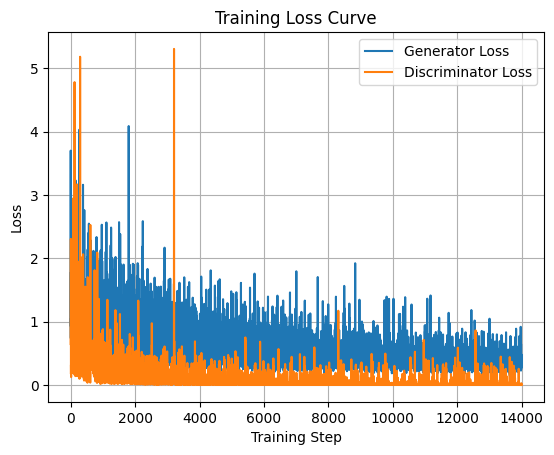

In [59]:
import re

gen_losses = []
disc_losses = []

with open("training_output.txt", "r") as f:
    for line in f:
        match = re.search(
            r"Generator Loss ([\d.]+), Discriminator Loss ([\d.]+)",
            line)
        if match:
            gen_losses.append(float(match.group(1)))
            disc_losses.append(float(match.group(2)))

plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


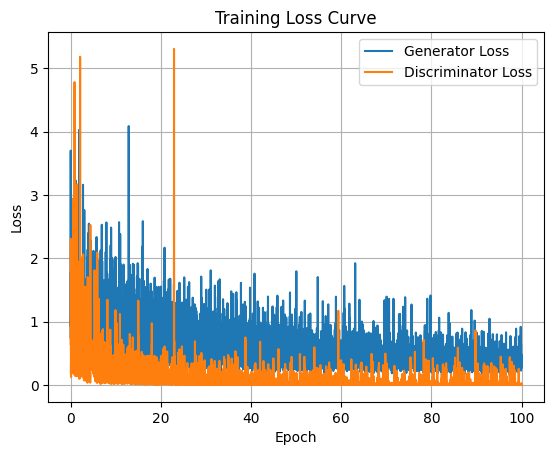

In [100]:
import re
import matplotlib.pyplot as plt
import numpy as np

gen_losses = []
disc_losses = []

# Read the data from the file
with open("training_output.txt", "r") as f:
    for line in f:
        match = re.search(
            r"Generator Loss ([\d.]+), Discriminator Loss ([\d.]+)", 
            line)
        if match:
            gen_losses.append(float(match.group(1)))
            disc_losses.append(float(match.group(2)))

# Convert step indices to epoch numbers
steps = np.arange(len(gen_losses))
epochs = steps / 140  # Each 140 steps = 1 epoch

# Plot the loss curves
plt.plot(epochs, gen_losses, label="Generator Loss")
plt.plot(epochs, disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


1.2541162e-05 0.39064652


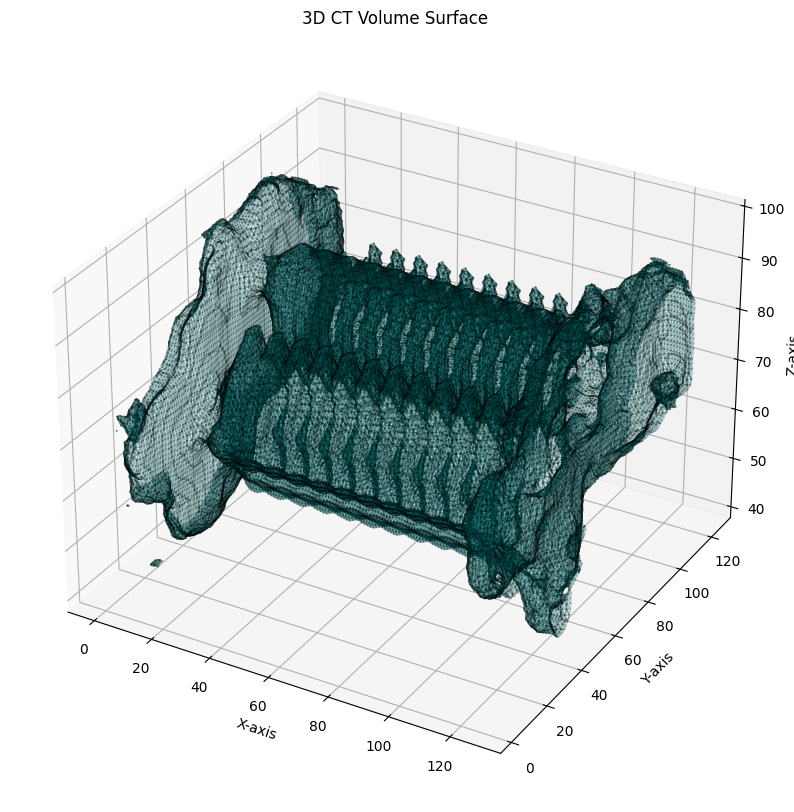

In [136]:
gen_ct = np.load('./Generated_Volumes/test/generated_ct15.npy')
# gen_ct = np.load('./Examples_Diss/generated_ct140.npy')
gen_ct = np.squeeze(gen_ct)
# print(gen_ct.shape)

gen_ct = gen_ct.astype(np.float32)
# gen_ct = normalise_ct_hu(gen_ct)
# print(gen_ct.shape)
print(gen_ct.min(), gen_ct.max())

# threshold = (gen_ct.max()-gen_ct.min())*0.5+gen_ct.min() 
# print(threshold)


plot_ct_surface(gen_ct, 0.305)

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from matplotlib import animation

#Loading volume
gen_ct = np.load('./Examples_Diss/generated_ct15.npy')
gen_ct = np.squeeze(gen_ct).astype(np.float32)

spacing = (1.0, 1.0, 1.7)

verts, faces, _, _ = marching_cubes(gen_ct, 
                                    level=0.305, 
                                    spacing=spacing)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot mesh
mesh = Poly3DCollection(verts[faces], alpha=0.35, facecolor='cyan')
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

x_vals, y_vals, z_vals = verts[:, 0], verts[:, 1], verts[:, 2]
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_zlim(z_vals.min(), z_vals.max())

#Making sure proportions match physical space
ax.set_box_aspect([
    x_vals.max() - x_vals.min(),
    y_vals.max() - y_vals.min(),
    z_vals.max() - z_vals.min()
])

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

#rotation animation
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

rot_anim = animation.FuncAnimation(fig, rotate, 
                                   frames=np.arange(0, 360, 2), 
                                   interval=50)
rot_anim.save('Vid_Gen_ct15.mp4', fps=20, bitrate=1800)

plt.close()


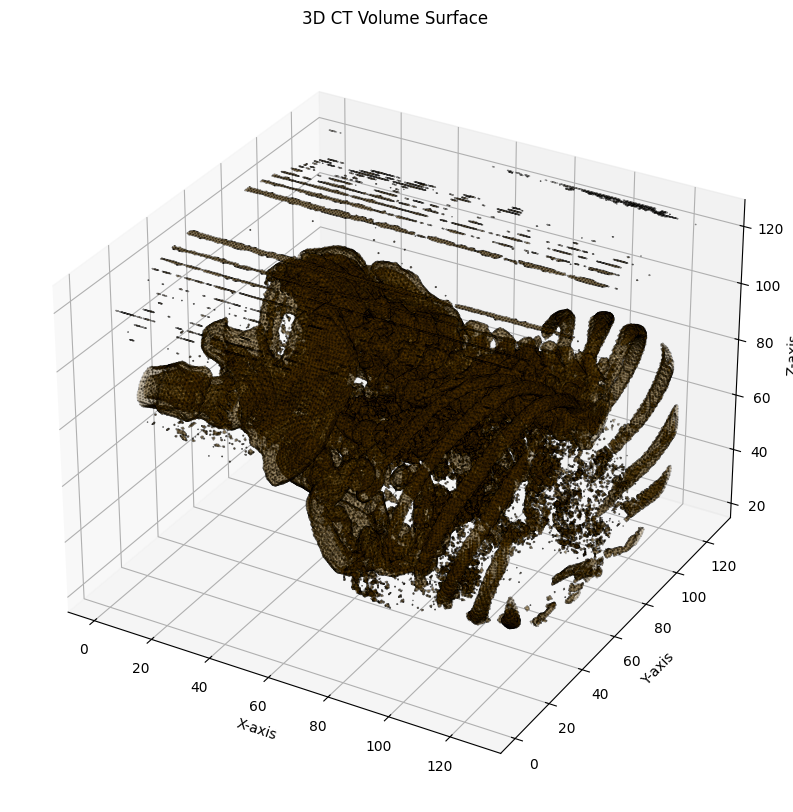

In [141]:
# gen_ct = np.load('./Generated_Volumes/test/generated_ct10.npy')
# for pa_xray, lat_xray, ct_scan in paired_ds.take(1):
#     ct_scan_np = ct_scan.numpy()
# ct_scan_np = np.squeeze(ct_scan_np)

# ct_scan_np = ct_scan_np.astype(np.float32)

# print(ct_scan_np.shape)
# print(ct_scan_np.min(), ct_scan_np.max())
# for thresh in [0.1,0.2,0.4,0.45,0.49,0.5,0.55, 0.6,0.7,0.75,0.8,0.9]:
plot_ct_surface(ct_scan_np, 0.45)

# plot_ct_surface(ct_scan_np, 0.6629)
# plot_ct_surface(ct_scan_np, 0.708)